### Link to the presentation video: https://www.youtube.com/watch?v=RSey5CtPe3g&feature=youtu.be

# Problem Statement
## FIFA 20
Football is arguably the most popular sport in the world and FIFA is the most popular football (soccer) simulation game by Electronic Arts (EA Sports). 

The game is not to be confused with the official International Federation for Football (FIFA).

You are given the following public dataset, scraped from https://sofifa.com. The data lists soccer players from the 2015-2020 editions of EA Sports FIFA video game. It consists of player positions, player attributes and personal data.


## Problem 
The player club changes can be tracked using the unique Sofifa id across all years. The problem statement is as follows: 

## Part A - Rank the Players      
- Who is the best player in the world according to your analysis?
- Use data from FIFA 19. Predict the Overall (OVR ) skill Statistic for players in the FIFA 20 Edition. Train on all players from FIFA 19

- Graphically represent the Overall data for the players in test set (see below)

### Instructions : 
- Sofifa Id, URL, Name, Potential, Real face, URL variables cannot be used during the prediction or learning. 

- In case of a change in playing position, alter FIFA 20 position to match FIFA 19 Position 

- The final score will be assigned using MSE. 

- Test Set: Players from the following Clubs 

  - FC Barcelona

  - FC Bayern München

  - Real Madrid 

  - Paris Saint-Germain

  - Juventus

  - Manchester City

  - Liverpool FC

----------------------------------------------------------------------------------------------------------------

### Importing all the necessary libraries

In [3]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import warnings; warnings.simplefilter('ignore')

#custom function
from preprocess import preprocess
%matplotlib inline

pd.set_option('display.max_columns', 100)

### Load the dataset

In [2]:
fifa_19 = pd.read_csv('players_19.csv')

unique_players = fifa_19.sofifa_id.nunique()
print("Total number of unique players:", unique_players)

fifa_19.head()

Total number of unique players: 17770


,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,Juventus,94,94,77000000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,127100000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Diver, Flair, Long Shot Taker...",84,94,89,81,87,88,...,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,FC Barcelona,94,94,110500000,565000,"CF, RW, ST",Left,5,4,4,Medium/Medium,Messi,Yes,226500000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",RW,10.0,NaN,2004-07-01,2021.0,CF,10.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (CPU AI Only), S...",77,95,70,90,86,97,...,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,90+2,84+2,84+2,84+2,90+2,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,93,118500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,228100000.0,"#Speedster, #Dribbler, #FK Specialist, #Acroba...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,"Diver, Selfish, Flair, Speed Dribbler (CPU AI ...",79,87,62,84,84,96,...,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27,1990-11-07,193,76,Spain,Manchester United,91,93,72000000,260000,GK,Right,4,3,1,Medium/Medium,Lean,Yes,138600000.0,NaN,GK,1.0,NaN,2011-07-01,2019.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,"GK Long Throw, Saves with Feet",17,13,21,50,13,18,...,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27,1991-06-28,181,70,Belgium,Manchester City,91,92,102000000,355000,"CAM, CM",Right,4,5,4,High/High,Normal,Yes,196400000.0,"#Dribbler, #Playmaker , #Engine, #Distance Sh...",RCM,17.0,NaN,2015-08-30,2023.0,RCM,7.0,77.0,86.0,92.0,87.0,60.0,78.0,NaN,N

# Exploratory Data Analysis

**We visualize the dataset to get a better idea of what the predictors look like and if they reveal patterns, corrleations, null values and imbalance in the dataset. Anything to help us better clean the data and make good inferences**

In [3]:
# calculate correlation of all features with respect to 'Overall'
corr = fifa_19.corr()["overall"].sort_values(ascending=False)

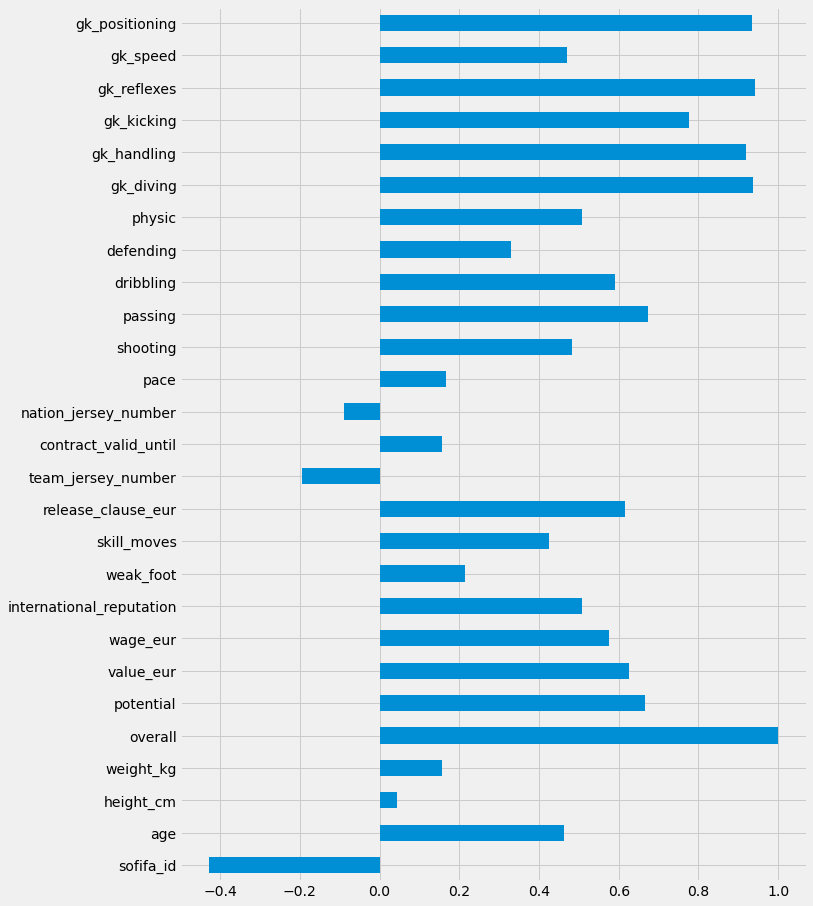

In [4]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 15))
fifa_19.corr()['overall'].plot.barh()
plt.show()

**Some predictors show suprious correlation with our response variable "Overall". For example, the sofifa_id, a predictor that has no relation with the response variable shows a neagtive correlation. While discarding this might seem obvious in this scenario (because it is an ID and the problem statement also hints at it), it is not always easy to identify such predictors without computing their correlation measure.** 

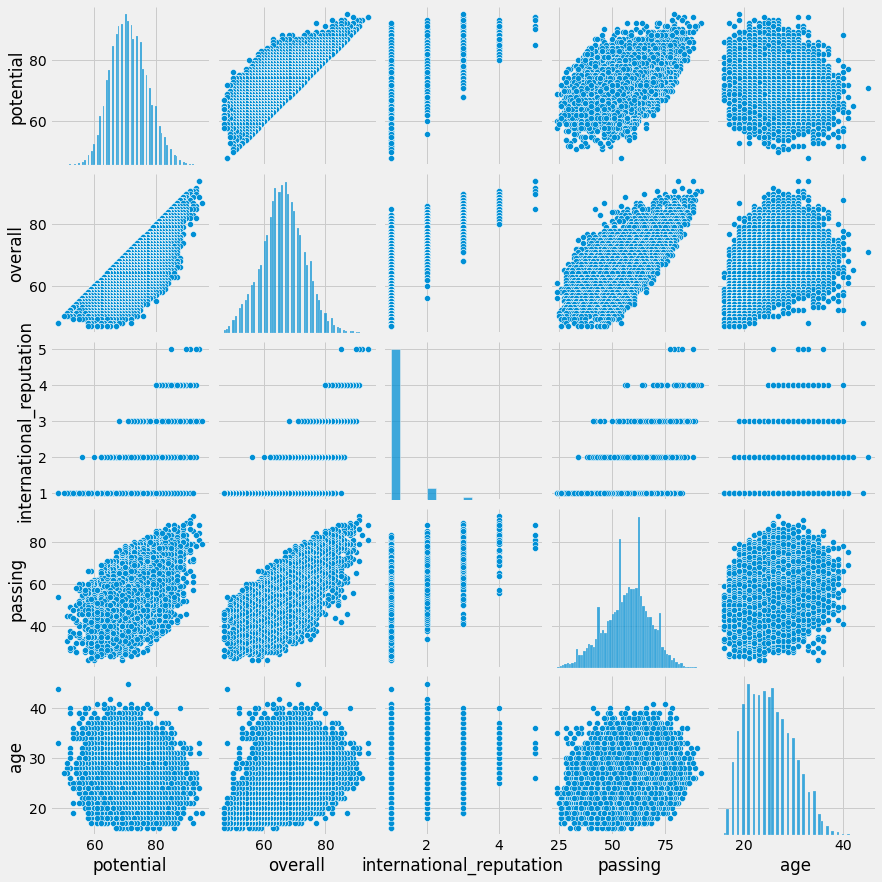

In [5]:
cols = fifa_19[['potential', 'overall', 'international_reputation', 'passing', 'age']]   
sns.pairplot(cols)
plt.show()

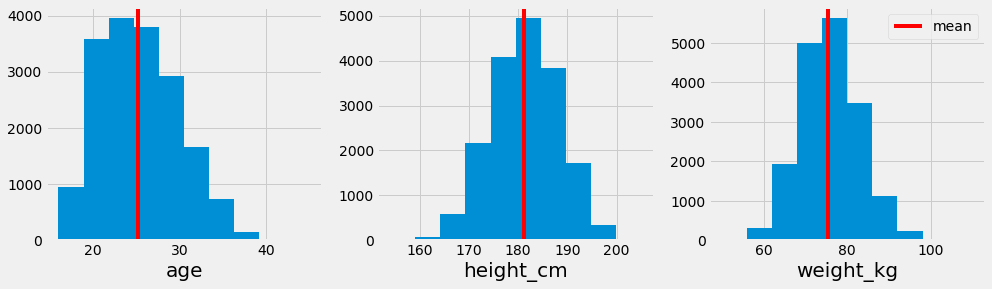

In [6]:
cols = ['age', 'height_cm', 'weight_kg']
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(cols):
    ax[i].hist(fifa_19[col])
    ax[i].set_xlabel(col, fontsize=20)
    ax[i].axvline(fifa_19[col].mean(),color='red', label="mean")
plt.legend()
plt.show()

**It can also be helpful to look at the age demographics and other such details to get an idea about how the data is collected (to look for possible biases) or in this case, that the data is faithful to its observations.** 

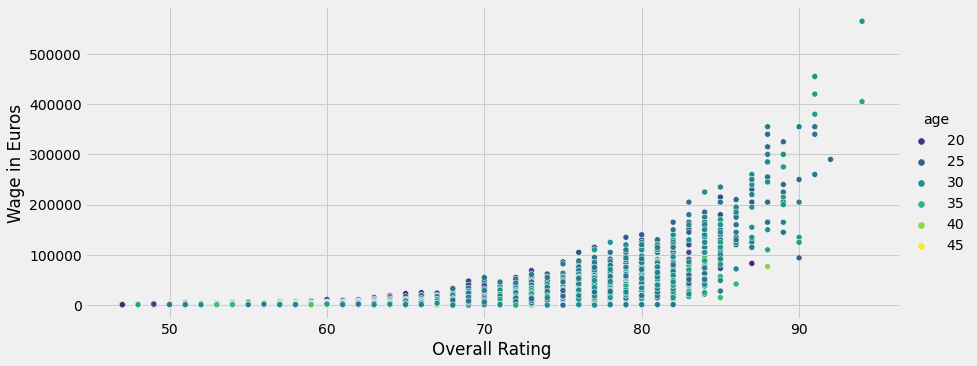

In [7]:
# wage_eur vs overall
sns.relplot(x='overall',y='wage_eur',hue='age',palette = 'viridis', sizes=(15, 200),aspect=2.5,data=fifa_19)
plt.xlabel('Overall Rating')
plt.ylabel('Wage in Euros')
plt.show()

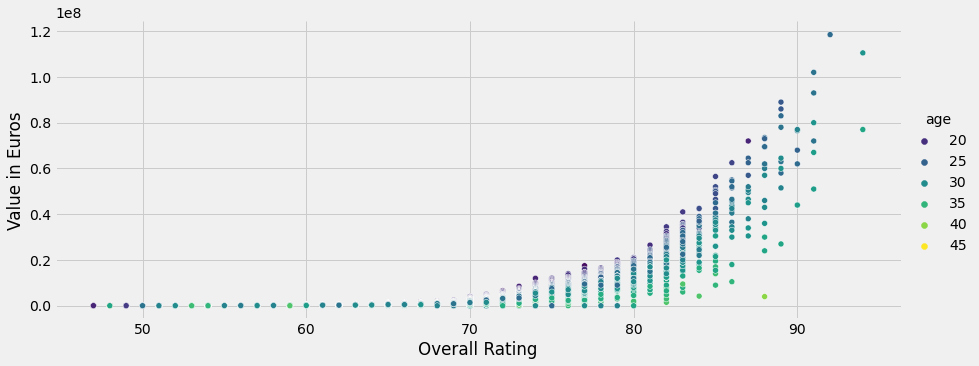

In [8]:
sns.relplot(x='overall',y='value_eur',hue='age',palette = 'viridis', sizes=(15, 200),aspect=2.5,data=fifa_19)
plt.xlabel('Overall Rating')
plt.ylabel('Value in Euros')
plt.show()

**In the following plots we look at the top players and see how well they rank given their clubs, nationality, reputation and see which team positions do the top 100 players hold.**

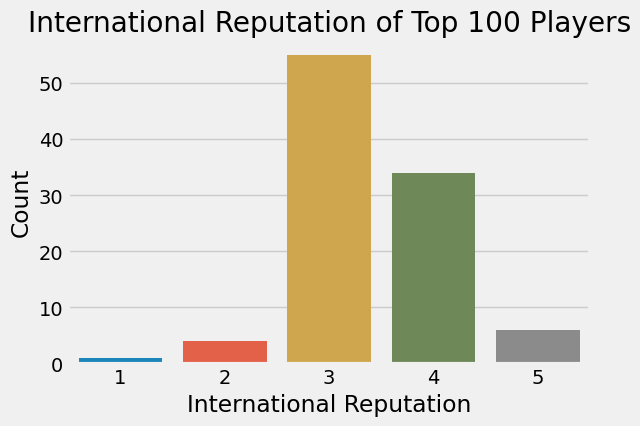

In [24]:
# sns.set_style('white')
plt.figure(dpi=100)
sns.countplot(x='international_reputation', data=fifa_19.head(100))
plt.xlabel('International Reputation')
plt.ylabel('Count')
plt.title('International Reputation of Top 100 Players')
plt.show()

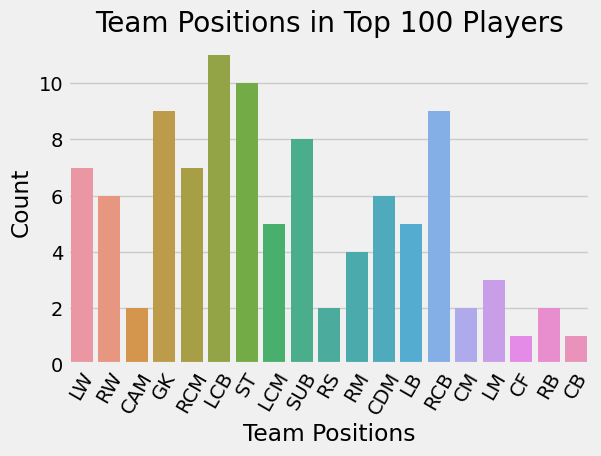

In [25]:
plt.figure(dpi=100)
sns.countplot(x='team_position', data=fifa_19.head(100))
plt.xlabel('Team Positions')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.title('Team Positions in Top 100 Players')
plt.show()

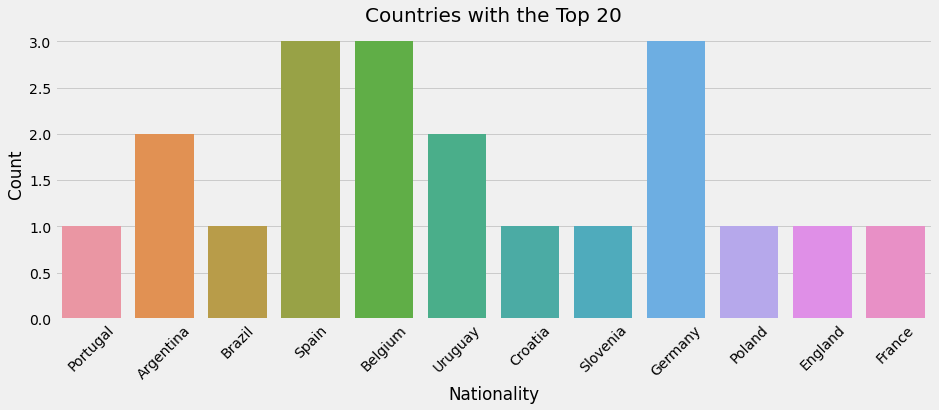

In [26]:
plt.figure(figsize=(14,5))
sns.countplot(x='nationality', data=fifa_19.head(20))
plt.xlabel('Nationality')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Countries with the Top 20',fontsize = 20)
plt.show()

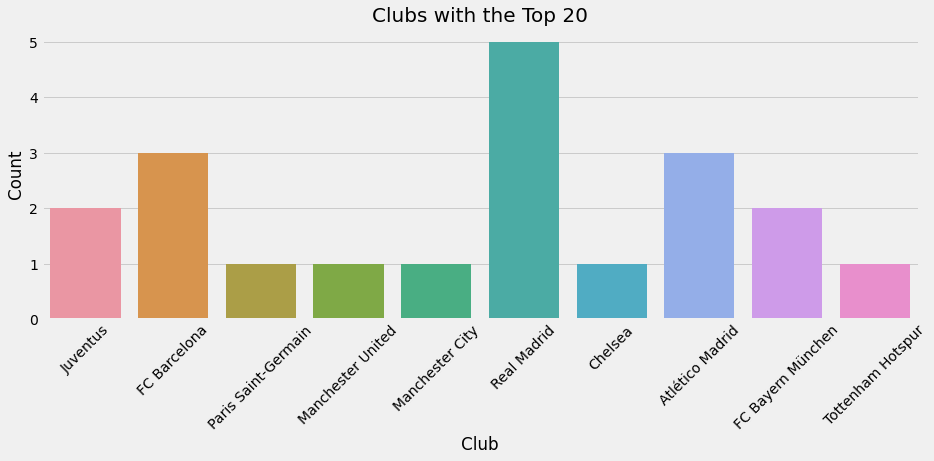

In [29]:
plt.figure(figsize=(14,5))
sns.countplot(x='club', data=fifa_19.head(20))
plt.xlabel('Club')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Clubs with the Top 20',fontsize = 20)
plt.show()

**Could a predictor make a difference in the our predictions? We can check for such imbalanced data and see its influence on our training set by including and excluding such predictors. Below are examples of where one might have to be cautious and decide how to handle such predictors.**

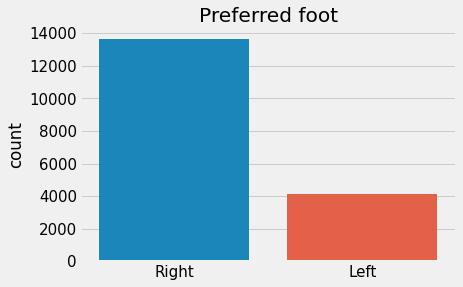

In [30]:
# count number of players by preferred foot
sns.countplot(x=fifa_19.preferred_foot)
plt.title("Preferred foot")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.show()

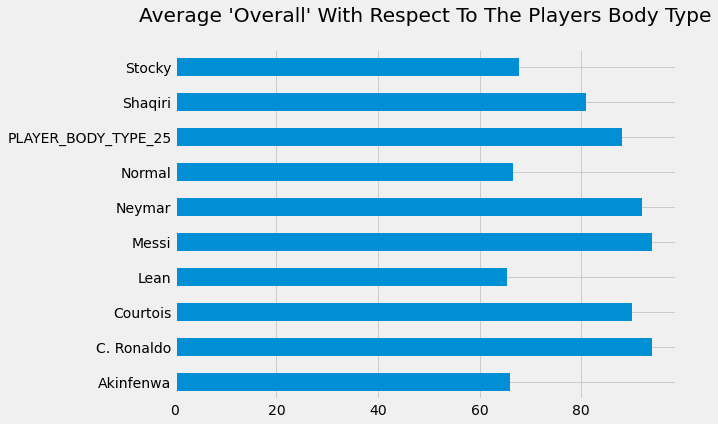

In [31]:
# average overall with respect to body type
plt.figure(figsize=(8, 6))
fifa_19.groupby('body_type')['overall'].mean().plot.barh()
plt.ylabel('')
plt.title("Average 'Overall' With Respect To The Players Body Type\n")
# plt.savefig('body_type.pdf', bbox_inches='tight', transparent=True)
plt.show()

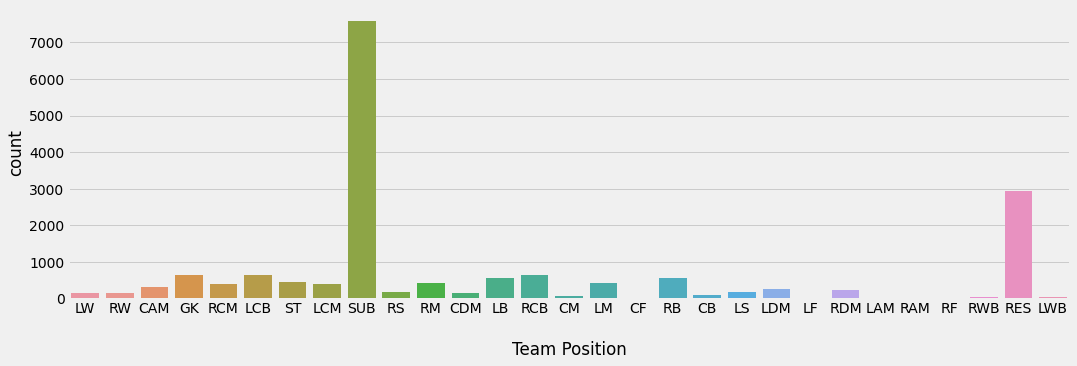

In [32]:
plt.figure(figsize=(16, 5))
sns.countplot(x=fifa_19.team_position)
plt.xlabel("\nTeam Position")
# plt.savefig('team_position_count.pdf', bbox_inches='tight', transparent=True)
plt.show()

# Preprocess: Data Cleaning & Handling Missing Values

**We created a function 'preprocess.py' to reduce clutter in the notebook. The function drops predictors such as sofifa_id, potential, loaned_from, team_positions, nation_postions, player_traits and a few more, in order to avoid either predictors that offer no valuable information, result in too many variable upon one hot encoding, or contain one too many null values. It also takes care of missing values in other predictors using Simple Imputer from sklearn. The code also makes sure that for predictors such as 'lm', 'lf', 'rf' etc, the null values are filled in with the mode of the distribution of that variable.**

In [33]:
# preprocess is a custom function that will drop all the unnecessary columns and 
# fills the missing values using appropriate strategy
fifa_19_prerpocessed = preprocess(fifa_19)

In [34]:
fifa_19_prerpocessed.head()

,age,height_cm,weight_kg,overall,value_eur,wage_eur,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,release_clause_eur,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,33,187,83,94,77000000,405000,Right,5,4,5,High/Low,127100000.0,2022.0,90.000000,93.000000,81.000000,89.000000,35.000000,79.000000,65.374622,62.931017,61.511078,66.149043,38.67573,63.088117,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61
1,31,170,72,94,110500000,565000,Left,5,4,4,Medium/Medium,226500000.0,2021.0,88.000000,91.000000,88.000000,96.000000,32.000000,61.000000,65.374622,62.931017,61.511078,66.149043,38.67573,63.088117,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88,88,88,92,93,93,93,92,93,93,93,90,84,84,84,90,63,61,61,61,63,58,47,47,47,58
2,26,175,68,92,118500000,290000,Right,5,5,5,High/Medium,228100000.0,2022.0,92.000000,84.000000,83.000000,95.000000,32.000000,59.000000,65.374622,62.931017,61.511078,66.149043,38.67573,63.088117,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60
3,27,193,76,91,72000000,260000,Right,4,3,1,Medium/Medium,138600000.0,2019.0,67.815319,52.248733,57.082172,62.267169,51.665484,64.972567,90.000000,85.000000,87.000000,94.000000,58.00000,88.000000,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,60,60,60,63,61,61,61,63,62,62,62,61,60,60,60,61,59,62,62,62,59,61,63,63,63,61
4,27,181,70,91,102000000,355000,Right,4,5,4,High/High,196400000.0,2023.0,77.000000,86.000000,92.000000,87.000000,60.000000,78.000000,65.374622,62.931017,61.511078,66.149043,38.67573,63.088117,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73


In [35]:
# OneHotEncode Categorical Variables
fifa_dummies = pd.get_dummies(fifa_19_prerpocessed, drop_first=True)
# print the shape
fifa_dummies.shape

(17770, 92)

## Split into training and testing data

In [36]:
# copy the onehotencoded dataframe
fifa_final = fifa_dummies.copy()
# separate the predictors and response variables
X = fifa_final.drop('overall', axis=1)
y = fifa_final.overall

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14216, 91), (3554, 91), (14216,), (3554,))

# Train Different Models

**Using:**
**1. Linear Regression**
**2. KNN Regression**
**3. Random Forest**

**We also define two functions called 'display' and 'train and evaluate' to reduce the number of code lines and also to avoid confusion amongst ourselves when running several models.**



In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def display(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std:", scores.std())

In [38]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model_scores = {}
    
    # cross-validation
    scores = cross_val_score(model, X_train_sc, y_train, cv=10, scoring='neg_mean_squared_error')
    scores = -(scores)
    mean_score = scores.mean()
    std = scores.std()
    model_scores["mean"] = f"{mean_score:.2f}"
    model_scores['standard_deviation'] = f"{std:.2f}"
    return model_scores

In [39]:
# creating an object of three different models
lreg = LinearRegression()
knn = KNeighborsRegressor()
rf = RandomForestRegressor(n_estimators=233)

lreg_score = train_and_evaluate(lreg, X_train_sc, y_train, X_test_sc, y_test)
knn_score = train_and_evaluate(knn, X_train_sc, y_train, X_test_sc, y_test)
rf_score = train_and_evaluate(rf, X_train_sc, y_train, X_test_sc, y_test)

scores = [lreg_score, knn_score, rf_score]

In [40]:
scores_df = pd.DataFrame(scores, index =["Linear Regression", "KNeighbors Regressor", "Random Forest Regressor"])
scores_df.columns = ["MSE", "STD"]
scores_df

,MSE,STD
Linear Regression,4.79,0.11
KNeighbors Regressor,2.49,0.07
Random Forest Regressor,0.41,0.06


**We have a clear winner with Random Forest which is better at handling predictors which are linear and non linear, continuous and discrete all thanks to the decision trees they use.**

# Training Random Forest Model On Whole Dataset

**While several of the Random Forest can be hyper tuned to get the best set of parameters to fit on our test data, we decided against it as we realised it was beyond the scope of this project and that we didn't have sufficient knowldege of this algorithm in order to choose which values for the arguments are best suited for RandomForestRegressor function.**

In [41]:
fifa_final = fifa_dummies.copy()
X = fifa_final.drop('overall', axis=1)
y = fifa_final.overall

# scale the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestRegressor(n_estimators=233)
rf.fit(X_scaled, y)

RandomForestRegressor(n_estimators=233)

In [42]:
# saving the trained model
joblib.dump(rf,'best_rf.h5')

['best_rf.h5']

**We have finally arrived at our best model and we can now use it on our test data**

## Predict on 2020 Fifa Dataset

In [43]:
# load fifa 2020 dataset
fifa_2020 = pd.read_csv('players_20.csv')

# filter out the clubs which will be used for prediction
clubs = ['FC Barcelona', 'FC Bayern München', 'Real Madrid', 'Paris Saint-Germain', 'Juventus', 'Manchester City', 'Liverpool']

# preprocess the data
fifa_20_cleaned = preprocess(fifa_2020, True)

# assign categorical columns to be one hot encoded
OneHotCols = ['preferred_foot', 'work_rate']

# OneHotEncode categorical columns
final_dummies = pd.get_dummies(fifa_20_cleaned, columns=OneHotCols, drop_first=True)

# only keep necessary rows
def func(se):
    if se in clubs:
        return True
    return False 

final_dummies['mask'] = final_dummies.club.apply(func)
final_test = final_dummies[final_dummies['mask']]

In [44]:
# separate predictor and response. 
X_test = final_test.drop(['overall', 'club', 'mask', 'short_name'], axis=1)
y_test = final_test.overall

# scale the X_test
X_test_scaled = scaler.transform(X_test)

In [45]:
# load model
model = joblib.load('best_rf.h5')
# make prediction using the trained model
final_preds = model.predict(X_test_scaled)
# print mean squared error
print("Mean Squared Error: {:.3f}".format(mean_squared_error(y_test, final_preds)))

Mean Squared Error: 0.529


In [46]:
# Create a dataframe using necessary columns that will be used for visualizaiton
df = final_test[['club', 'overall', 'short_name']].copy()

# # add prediction to the dataframe
df['prediction'] = final_preds

# # sort the datafame in descending order by predictions
df_sorted = df.sort_values(by='prediction', ascending=False)

# # print top 5 predicted players
df.head()

,club,overall,short_name,prediction
0,FC Barcelona,94,L. Messi,92.832618
1,Juventus,93,Cristiano Ronaldo,91.605150
2,Paris Saint-Germain,92,Neymar Jr,91.107296
4,Real Madrid,91,E. Hazard,91.141631
5,Manchester City,91,K. De Bruyne,90.695279


**Messi makes it to the top (at least according to our data and model)**

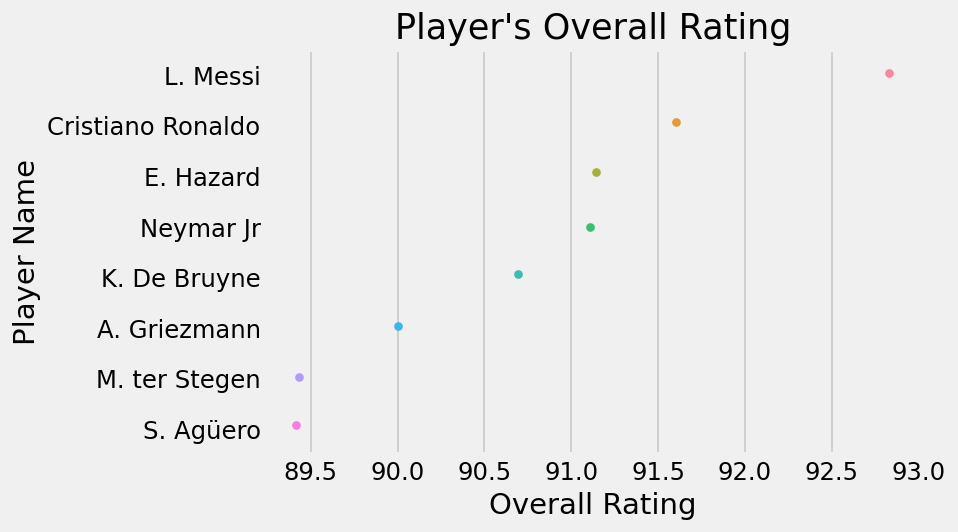

In [47]:
#testing this plot with that below for better visuals
plt.figure(dpi=125)
sns.stripplot(x = df_sorted.head(8)['prediction'], y = df_sorted.head(8)['short_name'], data = df_sorted.head(8))
plt.xlabel('Overall Rating')
plt.ylabel('Player Name')
plt.title('Player\'s Overall Rating')
plt.savefig("player_best.pdf", transparent=True, bbox_inches='tight')
plt.show()

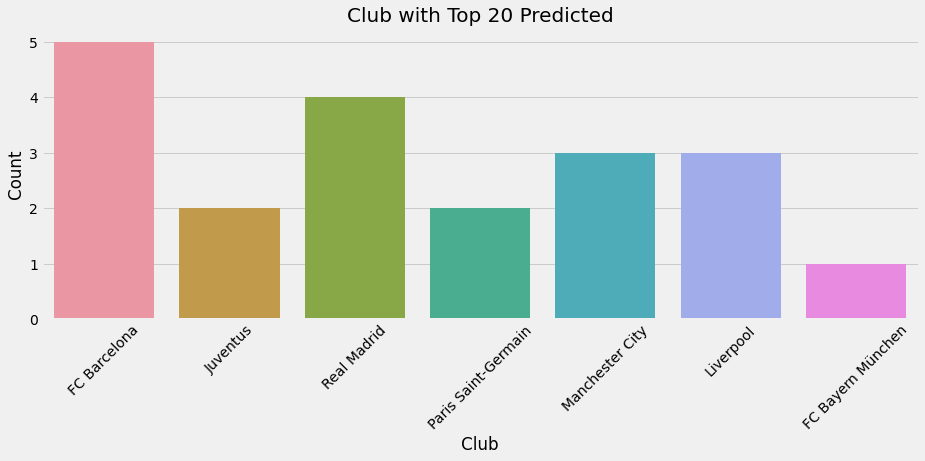

In [53]:
plt.figure(figsize=(14,5))
sns.countplot(x='club',data=df_sorted.head(20))
plt.xlabel('Club')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Club with Top 20 Predicted',fontsize = 20)
#plt.savefig("club_top_20.pdf", bbox_inches='tight', transparent=True)
plt.show()

In [54]:
# get top 10 predicted scores
top_10_predictions = df_sorted.iloc[:10, 3].values
# get first 10 actual scores 
actual = df_sorted.iloc[:10, 1].values
# get the names of the first 10 players
top_10_players = df_sorted.iloc[:10, 2].values

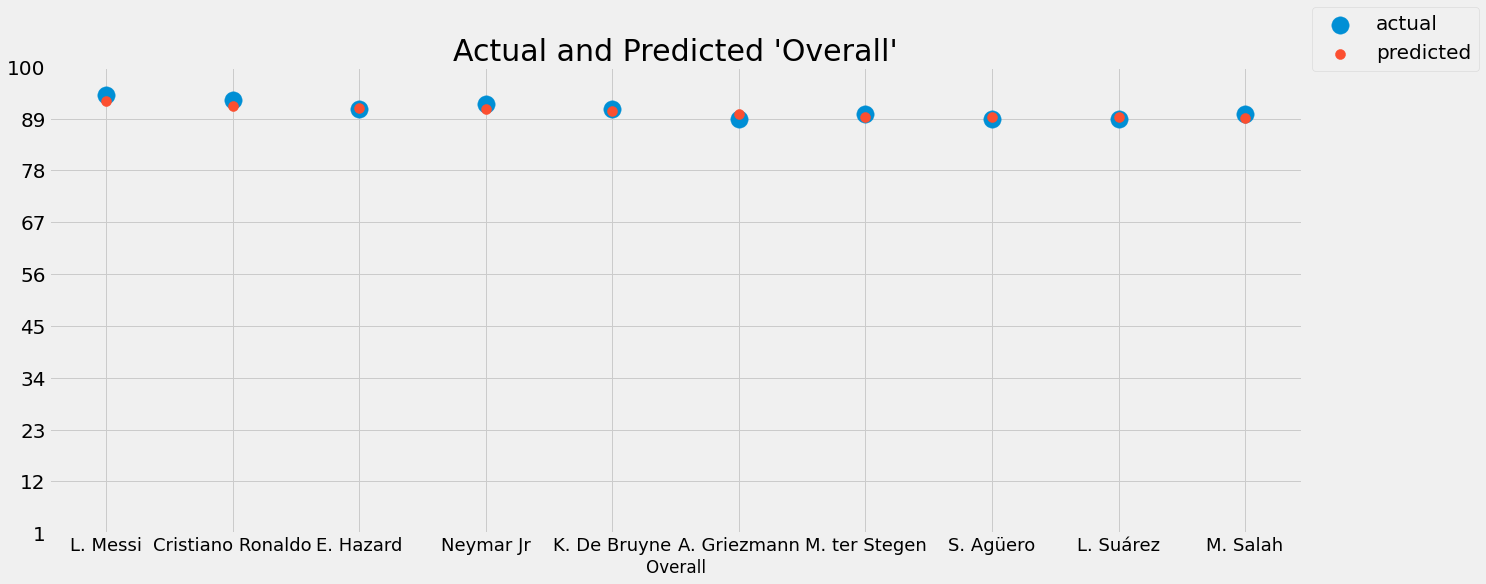

In [55]:
# create xticks for side-by-side bar plot. 
xticks1 = np.arange(10)
xticks2 = xticks1+0.4

plt.style.use('fivethirtyeight')
# plot
plt.figure(figsize=(20, 8))
plt.scatter(xticks1,actual, label="actual", s=300)
plt.scatter( xticks1,top_10_predictions, label="predicted", s=100)
plt.xticks(xticks1, top_10_players, fontsize=18)
plt.yticks(np.linspace(1, 100, 10), fontsize=20)
plt.title("Actual and Predicted 'Overall'", fontsize=30)
plt.xlabel("Overall")
plt.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1, 1.15))
plt.show()

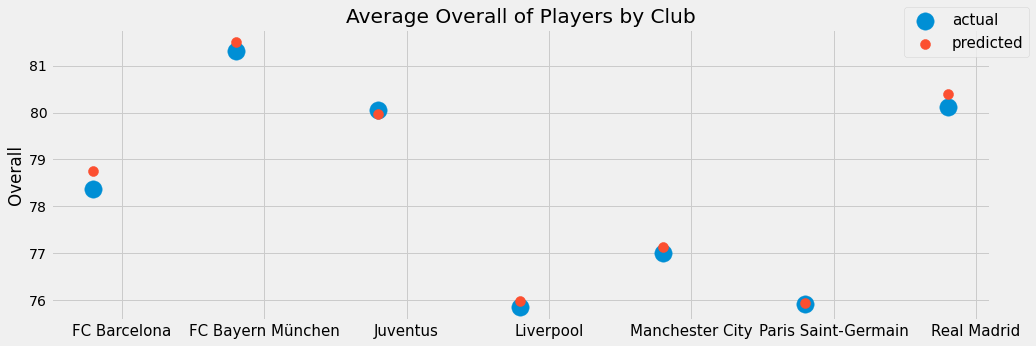

In [56]:
ax = df.groupby('club')['overall'].mean()
ax1 = df.groupby('club')['prediction'].mean()
# plot
plt.figure(figsize=(15, 5))
plt.scatter([1, 1.5, 2, 2.5, 3, 3.5, 4], ax.values, label="actual", s=300)
plt.scatter([1, 1.5, 2, 2.5, 3, 3.5, 4], ax1.values, label="predicted", s=100)
plt.xticks([1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1], labels=list(ax.index), fontsize=15)
plt.ylabel("Overall")
plt.title("Average Overall of Players by Club")
plt.legend(bbox_to_anchor=(0.9, 1.1), loc='upper left', fontsize=15)
#plt.savefig("club.pdf", bbox_inches='tight', transparent=True)
plt.show()

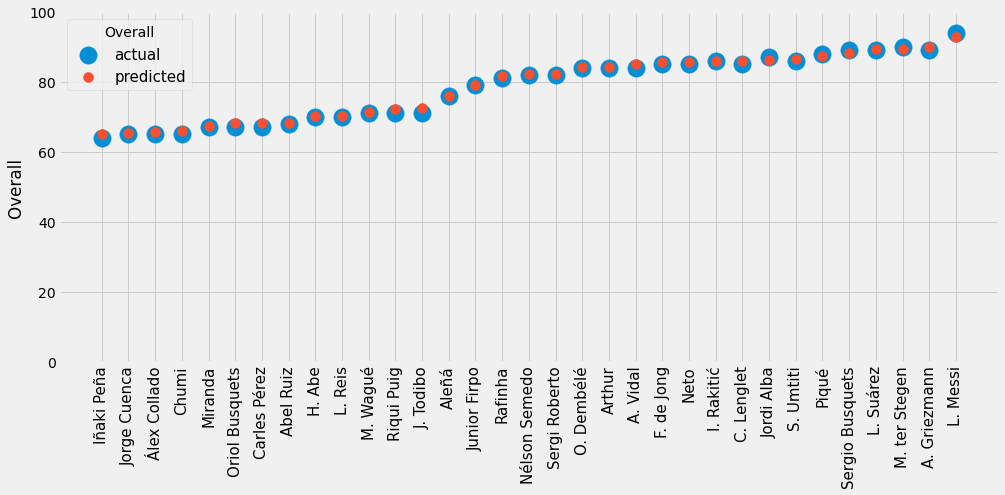

In [58]:
# plot barcelona's players overall
barca = df[df['club'] == 'FC Barcelona']
barca = barca.sort_values(by='prediction')
# plot
xticks = np.arange(len(barca))
plt.figure(figsize=(15, 6))
plt.scatter(xticks, barca.overall, label='actual', s=300)
plt.scatter(xticks, barca.prediction, label='predicted', s=100)
plt.ylim(0, 100)
plt.xticks(ticks=xticks, fontsize=15, rotation=90, labels=barca.short_name)
plt.ylabel("Overall")
plt.legend(title='Overall', loc='upper left', fontsize=15)
#plt.title("FC Barcelona Club Players Actual & Predicted Overall (Ascending Order)")
plt.show()

**We have now some interesting predictions that can prove valuable while investing in clubs and players and gives us not just the sole statistics of who the best player is but also which club is predicted to have the best overall and which club has the most number of predicted top 20 players.**

# ==============================================================

<h1>Part B - Classify player position</h1>

<h3>Can a professional defender become a forward?
Train on data from FIFA 19. 
Predict the player_position variable using other skill statistics for players in the FIFA 20 Edition. Train on all players from FIFA 19</h3>

**Graphically represent the predicted player_position for the players in Test Set** 

**Details :**

- Sofifa Id, URL, Wage, Salary, Name, Real face, URL variables cannot be used during the prediction or learning. *

- The final score will be assigned using Classification accuracy

- Test Set: Players from the following Clubs 

- FC Barcelona

- FC Bayern München

- Real Madrid 

- Paris Saint-Germain

- Juventus

- Atlético Madrid

- Manchester City

- Liverpool 

- Manchester United

Importing important Libraries and Packages

In [4]:
#import important libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OutputCodeClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf


Reading the FIFA 19 and 20 dataset

In [5]:
#read the csv files and have a look at all the columns
df_trn = pd.read_csv('players_19.csv')
df_tst = pd.read_csv('players_20.csv')
pd.set_option('display.max_columns', None)
clubs = ['Real Madrid', 'FC Barcelona', 'FC Bayern München', 'Paris Saint-Germain', 'Juventus', 'Atlético Madrid', 'Manchester City', 'Liverpool', 'Manchester United']
df_trn.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,Juventus,94,94,77000000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,127100000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Diver, Flair, Long Shot Taker...",84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,FC Barcelona,94,94,110500000,565000,"CF, RW, ST",Left,5,4,4,Medium/Medium,Messi,Yes,226500000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",RW,10.0,NaN,2004-07-01,2021.0,CF,10.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (CPU AI Only), S...",77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,90+2,84+2,84+2,84+2,90+2,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,93,118500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,228100000.0,"#Speedster, #Dribbler, #FK Specialist, #Acroba...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,"Diver, Selfish, Flair, Speed Dribbler (CPU AI ...",79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27,1990-11-07,193,76,Spain,Manchester United,91,93,72000000,260000,GK,Right,4,3,1,Medium/Medium,Lean,Yes,138600000.0,NaN,GK,1.0,NaN,2011-07-01,2019.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,"GK Long Throw, Saves with Feet",17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27,1991-06-28,181,70,Belgium,Manchester City,91,92,102000000,355000,"CAM, CM",Right,4,5,4,High/High,Normal,Yes,196400000.0,"#Dribbler, #Playmaker , #Eng

Defining Some Helper Functions for data processing

In [6]:
#define a function that gets one-hot-encoded column and deletes th previous column
def one_hot_encode(df,column):
    vals = pd.get_dummies(df[column])
    df = df.drop(column,axis=1)
    df = pd.concat((df,vals),axis=1)
    return df

def get_bmi(df):
    h = df['height_cm']/100
    w = df['weight_kg']
    bmi = w/h**2
    df = df.drop(['height_cm','weight_kg'],axis=1)
    bmi = pd.DataFrame(bmi,columns=['bmi'])
    df = pd.concat([df,bmi],axis=1)
    return df

Dropping the useess columns. Some columns which are dropped currently could be of use in future, they are listed in commnents

In [7]:
#Drop useless columns from both the datasets, some columns which were dropped but could be used to improve accuracy are :
#player_tags,player_traits,joined,nation_position,nation_jersey_number,team_jersey_number

useless = ['sofifa_id','player_url','short_name','long_name','dob','wage_eur','body_type','real_face','nationality','club','player_tags','body_type','player_traits','joined','nation_position','loaned_from','nation_jersey_number','team_jersey_number']
df_train = df_trn.drop(useless,axis=1)
df_test = df_tst.drop(useless,axis=1)
df_train.head()

,age,height_cm,weight_kg,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,33,187,83,94,94,77000000,"ST, LW",Right,5,4,5,High/Low,127100000.0,LW,2022.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,31,170,72,94,94,110500000,"CF, RW, ST",Left,5,4,4,Medium/Medium,226500000.0,RW,2021.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,90+2,84+2,84+2,84+2,90+2,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,26,175,68,92,93,118500000,"LW, CAM",Right,5,5,5,High/Medium,228100000.0,CAM,2022.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,27,193,76,91,93,72000000,GK,Right,4,3,1,Medium/Medium,138600000.0,GK,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27,181,70,91,92,102000000,"CAM, CM",Right,4,5,4,High/High,196400000.0,RCM,2023.0,77.0,86.0,92.0,87.0,60.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3


Team Position should be a good predictor for player position but due to too many NaN entries and a large variety
it becomes difficult to deal with, hence we will drop it later. But replacing NaN with a dummy position 'anywhere' is the part 
pre-processing currently

In [8]:
#Deat with NaN entries in team_position column
df_train['team_position'].fillna('Anywhere',inplace=True)
df_train['release_clause_eur'].fillna(1000)
df_test['release_clause_eur'].fillna(1000)
print(df_train['team_position'].isnull().sum())
print(df_train['work_rate'].isnull().sum())

0
0


Now we call on the helper functions and one-hot-encode the columns we though are usefu and have a reasonable variety of entries.
We also combine height and weight into a new column BMI

In [9]:
#Call previous function to one-hot-encode work_rate column
df_train = one_hot_encode(df_train,'work_rate')
df_train = get_bmi(df_train)
df_test = one_hot_encode(df_test,'work_rate')
df_test = get_bmi(df_test)
#df_train = df_train.drop('work_rate',axis=1)
#df_test = df_test.drop('work_rate',axis=1)
df_train.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,33,94,94,77000000,"ST, LW",Right,5,4,5,127100000.0,LW,2022.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,0,1,0,0,0,0,0,0,0,23.735308
1,31,94,94,110500000,"CF, RW, ST",Left,5,4,4,226500000.0,RW,2021.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,90+2,84+2,84+2,84+2,90+2,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2,0,0,0,0,0,0,0,0,1,24.913495
2,26,92,93,118500000,"LW, CAM",Right,5,5,5,228100000.0,CAM,2022.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,0,0,1,0,0,0,0,0,0,22.204082
3,27,91,93,72000000,GK,Right,4,3,1,138600000.0,GK,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,20.403232
4,27,91,92,102000000,"CAM, CM",Right,4,5,4,196400000.0,RCM,2023.0,77.0,86.0,92.0,87.0,60.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,1,0,0,0,0,0,0,0,0,21.366869


For the columns listed below the entry is of the form '87+3'. We need to make it into a form which can be interpreted as
an integer, hence'87' will be extracted. We also binary encode right and left in the preferred_foot column

In [10]:
#These columns have some entries of th type '87+3', extract ony the first part from these
columns = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm', 'cdm','rdm','rwb','lb','lcb','cb','rcb','rb']
for col in columns:
    df_train[col]=df_train[col].str.split('+',n=1,expand = True)[0]
    df_test[col]=df_test[col].str.split('+',n=1,expand = True)[0]
df_train['preferred_foot'] = df_train['preferred_foot'].replace(['Right','Left'],[1,0])
df_test['preferred_foot'] = df_test['preferred_foot'].replace(['Right','Left'],[1,0])
df_train.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,33,94,94,77000000,"ST, LW",1,5,4,5,127100000.0,LW,2022.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,0,1,0,0,0,0,0,0,0,23.735308
1,31,94,94,110500000,"CF, RW, ST",0,5,4,4,226500000.0,RW,2021.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88,88,88,92,93,93,93,92,93,93,93,90,84,84,84,90,63,61,61,61,63,58,47,47,47,58,0,0,0,0,0,0,0,0,1,24.913495
2,26,92,93,118500000,"LW, CAM",1,5,5,5,228100000.0,CAM,2022.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,0,0,1,0,0,0,0,0,0,22.204082
3,27,91,93,72000000,GK,1,4,3,1,138600000.0,GK,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,20.403232
4,27,91,92,102000000,"CAM, CM",1,4,5,4,196400000.0,RCM,2023.0,77.0,86.0,92.0,87.0,60.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,1,0,0,0,0,0,0,0,0,21.366869


The entries in these columns like the previous ones have entries of type '87-3' and '56+3'.
And we extract the first parts of these entires here.

In [11]:
#These columns have entries of the type '87-3' and '56+3'. Extract only the first part of these
columns = ['attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control','movement_acceleration','movement_sprint_speed','movement_agility','movement_reactions','movement_balance','power_shot_power','power_jumping','power_stamina','power_strength','power_long_shots','mentality_aggression','mentality_interceptions','mentality_positioning','mentality_vision','mentality_penalties','mentality_composure','defending_marking','defending_standing_tackle','defending_sliding_tackle','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning','goalkeeping_reflexes']
for col in columns:
    df_train[col] = df_train[col].str.replace('-','+')
    df_train[col]=df_train[col].str.split('+',n=1,expand = True)[0]
df_train.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,33,94,94,77000000,"ST, LW",1,5,4,5,127100000.0,LW,2022.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,0,1,0,0,0,0,0,0,0,23.735308
1,31,94,94,110500000,"CF, RW, ST",0,5,4,4,226500000.0,RW,2021.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88,88,88,92,93,93,93,92,93,93,93,90,84,84,84,90,63,61,61,61,63,58,47,47,47,58,0,0,0,0,0,0,0,0,1,24.913495
2,26,92,93,118500000,"LW, CAM",1,5,5,5,228100000.0,CAM,2022.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,0,0,1,0,0,0,0,0,0,22.204082
3,27,91,93,72000000,GK,1,4,3,1,138600000.0,GK,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,20.403232
4,27,91,92,102000000,"CAM, CM",1,4,5,4,196400000.0,RCM,2023.0,77.0,86.0,92.0,87.0,60.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,1,0,0,0,0,0,0,0,0,21.366869


GK are usually not assigned any value for the columns listed below. Hence they are read as NaN. We cannot replace NaN here with 0 as GK do not have 0 of these skills/stats. The minimum entry in each column was the same - 31. Hence GKs were assigned a value of 30 or less than 30 depending on the accuracy the value gives.

In [12]:
#Deal with NaN entries in these columns. Tried multiple things instead of justfilling NaN with 0
columns = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm', 'cdm','rdm','rwb','lb','lcb','cb','rcb','rb']
df_train[columns] = df_train[columns].fillna(20)
df_train[columns] = df_train[columns].astype(int)
columns = ['dribbling','defending','physic','passing','shooting','pace']
#df_train[columns] = df_train[columns].fillna(0)
for col in columns:
    df_train[col] = df_train[col].fillna(df_train[col].median())
df_train['contract_valid_until'] = df_train['contract_valid_until'].fillna(df_train['contract_valid_until'].max())
df_train[columns] = df_train[columns].astype(int)
df_train = df_train.fillna(0)
#df_train.isnull().sum()

Single player can have multiple player positions, but the exercise is to assign a single position to a player. Hence just one entry was maintained.

In [13]:
#Multiple player positions are present for a single player, extract only one out of those
df_train['player_positions'] = df_train['player_positions'].str.split(',',n=1,expand=True)[0]
df_train.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,33,94,94,77000000,ST,1,5,4,5,127100000.0,LW,2022.0,90,93,81,89,35,79,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,0,1,0,0,0,0,0,0,0,23.735308
1,31,94,94,110500000,CF,0,5,4,4,226500000.0,RW,2021.0,88,91,88,96,32,61,0.0,0.0,0.0,0.0,0.0,0.0,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88,88,88,92,93,93,93,92,93,93,93,90,84,84,84,90,63,61,61,61,63,58,47,47,47,58,0,0,0,0,0,0,0,0,1,24.913495
2,26,92,93,118500000,LW,1,5,5,5,228100000.0,CAM,2022.0,92,84,83,95,32,59,0.0,0.0,0.0,0.0,0.0,0.0,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60,0,0,1,0,0,0,0,0,0,22.204082
3,27,91,93,72000000,GK,1,4,3,1,138600000.0,GK,2019.0,69,54,58,64,56,66,90.0,85.0,87.0,94.0,58.0,88.0,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,0,0,0,0,0,0,0,0,1,20.403232
4,27,91,92,102000000,CAM,1,4,5,4,196400000.0,RCM,2023.0,77,86,92,87,60,78,0.0,0.0,0.0,0.0,0.0,0.0,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73,1,0,0,0,0,0,0,0,0,21.366869


Predictor variable and Response variable are separated. The predictor is normalised or standardised according to performance generated by each method

In [14]:
#Separating the predictor and response variables
y = df_train['player_positions']
y_nn = pd.get_dummies(y)
Xt = df_train.drop('player_positions',axis=1)
X_n = Xt.drop('team_position',axis=1)
X_norm = MinMaxScaler().fit_transform(X_n)
X_std = StandardScaler().fit_transform(X_n)
X = pd.DataFrame(X_std, index=X_n.index, columns=X_n.columns)
#X = pd.concat([X,Xt['team_position']],axis=1)
print(X.shape,y.shape)

(17770, 92) (17770,)


Trying out Logistic Regression for Classification. 

In [15]:
#Defining model and fitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8, random_state = 66)

model = LogisticRegression(max_iter=1e4, C=0.01, random_state=0)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)


validation_accuracy = accuracy_score(y_val, y_val_pred)
#model = OutputCodeClassifier(LogisticRegression(max_iter=10000,random_state=0,C=10000),code_size=1.5)
#model.fit(X,y)
#y_pred = model.predict(X)


In [16]:
#Getting training accuracy
#acc = accuracy_score(y,y_pred)
print('Validation Accuracy : ',validation_accuracy)

Validation Accuracy :  0.7478897017445132


Cleaning up test set in accordance to the train set and getting test accuracy

In [17]:
columns = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm', 'cdm','rdm','rwb','lb','lcb','cb','rcb','rb']
df_test[columns] = df_test[columns].fillna(30)
df_test[columns] = df_test[columns].astype(int)
columns = ['dribbling','defending','physic','passing','shooting','pace']

for col in columns:
    df_test[col] = df_test[col].fillna(df_test[col].median())
df_test[columns] = df_test[columns].astype(int)
df_test['contract_valid_until'] = df_test['contract_valid_until'].fillna(df_test['contract_valid_until'].max())
df_test = df_test.fillna(0)
df_test['player_positions'] = df_test['player_positions'].str.split(',',n=1,expand=True)[0]
df_test.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,32,94,94,95500000,RW,0,5,4,4,195800000.0,RW,2021.0,87,92,92,96,39,66,0.0,0.0,0.0,0.0,0.0,0.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89,89,89,93,93,93,93,93,93,93,93,92,87,87,87,92,68,66,66,66,68,63,52,52,52,63,0,0,0,0,0,0,0,1,0,24.913495
1,34,93,93,58500000,ST,1,5,4,5,96500000.0,LW,2022.0,90,93,82,89,35,78,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,0,1,0,0,0,0,0,0,0,23.735308
2,27,92,92,105500000,LW,1,5,5,5,195200000.0,CAM,2022.0,91,85,87,95,32,58,0.0,0.0,0.0,0.0,0.0,0.0,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84,84,84,90,89,89,89,90,90,90,90,89,82,82,82,89,66,61,61,61,66,61,46,46,46,61,0,0,1,0,0,0,0,0,0,22.204082
3,26,91,93,77500000,GK,1,3,3,1,164700000.0,GK,2023.0,69,54,58,64,56,66,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,0,0,0,0,0,0,0,0,1,24.615211
4,28,91,91,90000000,LW,1,4,4,4,184500000.0,LW,2024.0,91,83,86,94,35,66,0.0,0.0,0.0,0.0,0.0,0.0,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83,83,83,89,88,88,88,89,89,89,89,89,83,83,83,89,66,63,63,63,66,61,49,49,49,61,0,0,1,0,0,0,0,0,0,24.163265


In [18]:
y_test = df_test['player_positions']
y_test = y_test[df_tst['club'].isin(clubs)]
X_tst = df_test.drop(['player_positions','team_position'],axis=1)
X_test = X_tst[df_tst['club'].isin(clubs)]
X_test = StandardScaler().fit_transform(X_test)
X_tst = StandardScaler().fit_transform(X_tst)
y_pred_test = model.predict(X_test)
y_pred_t = model.predict(X_tst)
test_acc = accuracy_score(y_test,y_pred_test)
print('Test set accuracy: ',test_acc)

Test set accuracy:  0.7735191637630662


Understanding the results visually through a bar plot

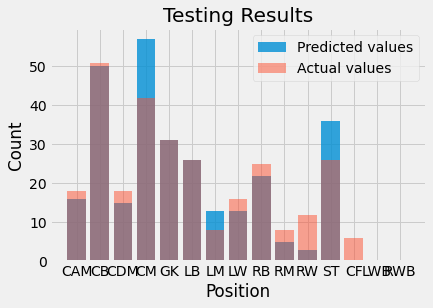

In [178]:
pos_dum = pd.get_dummies(y_pred_t)
pos_pred = pos_dum[df_tst['club'].isin(clubs)].sum(axis=0)
pos_ac = pd.get_dummies(df_test['player_positions'])
pos_actual = pos_ac[df_tst['club'].isin(clubs)].sum(axis=0)
plt.bar(pos_dum.columns,pos_pred,alpha=0.8,label='Predicted values')
plt.bar(pos_ac.columns,pos_actual,alpha=0.5,label='Actual values')
plt.title("Testing Results")
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend()
plt.show()

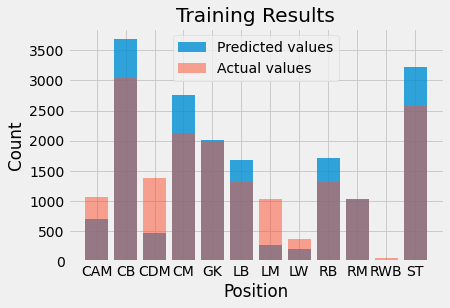

Index(['CAM', 'CB', 'CDM', 'CM', 'GK', 'LB', 'LM', 'LW', 'RB', 'RM', 'RWB',
       'ST'],
      dtype='object')

In [179]:
pos_pre = pd.get_dummies(y_pred)
pos_pred = pos_pre.sum(axis=0)
pos_actual = y_nn.sum(axis=0)
plt.bar(pos_pre.columns,pos_pred,alpha=0.8,label='Predicted values')
plt.bar(pos_pre.columns,pos_actual[pos_pre.columns],alpha=0.5,label='Actual values')
plt.title("Training Results")
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend()
plt.show()
pd.get_dummies(y_pred).columns

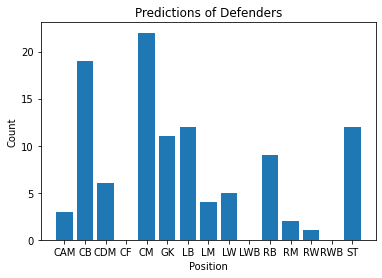

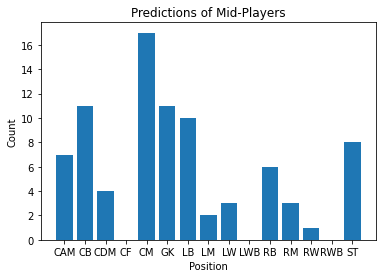

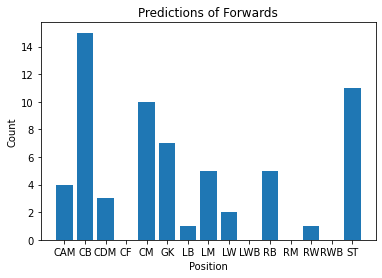

In [19]:
defenders = ['CB','CDM','LB','LWB','RB','RWB']
mid = ['CAM','CM','LM','RM']
forward = ['CF','LW','RW','ST']

y_test_nn = pd.get_dummies(df_test['player_positions'])
y_test_nn = y_test_nn[df_tst['club'].isin(clubs)]
y_nn = pd.get_dummies(df_train['player_positions'])
y_nn = y_nn[df_tst['club'].isin(clubs)]
y_19_actual = y_nn[df_tst['club'].isin(clubs)]
y_20_actual = y_test_nn
y_20_pr = pd.get_dummies(y_pred_t)
y_20_pre = y_20_pr[df_tst['club'].isin(clubs)]
y_20_pred = pd.DataFrame(y_20_pre, index=y_20_actual.index, columns=y_20_actual.columns)
pred_def = y_20_pred[(y_19_actual['CB'] == 1) | (y_19_actual['CDM'] == 1) | (y_19_actual['LB'] == 1) | (y_19_actual['LWB'] == 1)
                    | (y_19_actual['RB'] == 1) | (y_19_actual['RWB'] == 1)].sum(axis=0)
pred_mid = y_20_pred[(y_19_actual['CAM'] == 1) | (y_19_actual['CM'] == 1) | (y_19_actual['RM'] == 1) 
                    | (y_19_actual['LM'] == 1)].sum(axis=0)
pred_for = y_20_pred[(y_19_actual['CF'] == 1) | (y_19_actual['LW'] == 1) | (y_19_actual['RW'] == 1) 
                    | (y_19_actual['ST'] == 1)].sum(axis=0)

plt.figure()
plt.bar(y_nn.columns, pred_def)
plt.title('Predictions of Defenders')
plt.xlabel('Position')
plt.ylabel('Count')

plt.figure()
plt.bar(y_nn.columns, pred_mid)
plt.title('Predictions of Mid-Players')
plt.xlabel('Position')
plt.ylabel('Count')

plt.figure()
plt.bar(y_nn.columns, pred_for)
plt.title('Predictions of Forwards')
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()

Trying out the tuned K-Neighbors Classifier

In [89]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8, random_state = 66)

model = KNeighborsClassifier(22)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)


validation_accuracy = accuracy_score(y_val, y_val_pred)

In [90]:
print('Validation Accuracy : ',validation_accuracy)

Validation Accuracy :  0.6913337084974677


Cleaning up test set in accordance to the train set and getting test accuracy

In [160]:
columns = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm', 'cdm','rdm','rwb','lb','lcb','cb','rcb','rb']
df_test[columns] = df_test[columns].fillna(30)
df_test[columns] = df_test[columns].astype(int)
columns = ['dribbling','defending','physic','passing','shooting','pace']

for col in columns:
    df_test[col] = df_test[col].fillna(df_test[col].median())
df_test[columns] = df_test[columns].astype(int)
df_test['contract_valid_until'] = df_test['contract_valid_until'].fillna(df_test['contract_valid_until'].max())
df_test = df_test.fillna(0)
df_test['player_positions'] = df_test['player_positions'].str.split(',',n=1,expand=True)[0]
df_test.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,32,94,94,95500000,RW,0,5,4,4,195800000.0,RW,2021.0,87,92,92,96,39,66,0.0,0.0,0.0,0.0,0.0,0.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89,89,89,93,93,93,93,93,93,93,93,92,87,87,87,92,68,66,66,66,68,63,52,52,52,63,0,0,0,0,0,0,0,1,0,24.913495
1,34,93,93,58500000,ST,1,5,4,5,96500000.0,LW,2022.0,90,93,82,89,35,78,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,0,1,0,0,0,0,0,0,0,23.735308
2,27,92,92,105500000,LW,1,5,5,5,195200000.0,CAM,2022.0,91,85,87,95,32,58,0.0,0.0,0.0,0.0,0.0,0.0,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84,84,84,90,89,89,89,90,90,90,90,89,82,82,82,89,66,61,61,61,66,61,46,46,46,61,0,0,1,0,0,0,0,0,0,22.204082
3,26,91,93,77500000,GK,1,3,3,1,164700000.0,GK,2023.0,69,54,58,64,56,66,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,0,0,0,0,0,0,0,0,1,24.615211
4,28,91,91,90000000,LW,1,4,4,4,184500000.0,LW,2024.0,91,83,86,94,35,66,0.0,0.0,0.0,0.0,0.0,0.0,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83,83,83,89,88,88,88,89,89,89,89,89,83,83,83,89,66,63,63,63,66,61,49,49,49,61,0,0,1,0,0,0,0,0,0,24.163265


In [161]:
y_test = df_test['player_positions']
y_test = y_test[df_tst['club'].isin(clubs)]
X_tst = df_test.drop(['player_positions','team_position'],axis=1)
X_test = X_tst[df_tst['club'].isin(clubs)]
X_test = StandardScaler().fit_transform(X_test)
X_tst = StandardScaler().fit_transform(X_tst)
y_pred_test = model.predict(X_test)
y_pred_t = model.predict(X_tst)
test_acc = accuracy_score(y_test,y_pred_test)
print('Testing accuracy: ', test_acc)

Testing accuracy:  0.7735191637630662


Making an MLP and training it

In [20]:
#Neural Network approach

y_nn = pd.get_dummies(df_train['player_positions'])
#y_nn = y_nn[df_trn['club'].isin(clubs)]
model = tf.keras.models.Sequential(name='MLP')
model.add((tf.keras.layers.Dense(30,input_dim=X.shape[1], activation = 'relu',name='hidden1')))
model.add((tf.keras.layers.Dense(32, activation = 'relu',name='hidden2')))
#model.add((tf.keras.layers.Dense(45, activation = 'relu',name='hidden3')))
model.add(tf.keras.layers.Dense(y_nn.shape[1], activation = 'softmax',name='output'))

# early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(X, y_nn, epochs = 1000, batch_size = 16, validation_split=0.2, callbacks=[early_stopping_cb])

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 30)                2790      
_________________________________________________________________
hidden2 (Dense)              (None, 32)                992       
_________________________________________________________________
output (Dense)               (None, 15)                495       
Total params: 4,277
Trainable params: 4,277
Non-trainable params: 0
_________________________________________________________________
Train on 14216 samples, validate on 3554 samples
Epoch 1/1000
14216/14216 [==============================] - 2s 115us/sample - loss: 1.4055 - accuracy: 0.5479 - val_loss: 1.2219 - val_accuracy: 0.5889
Epoch 2/1000
14216/14216 [==============================] - 1s 89us/sample - loss: 0.8935 - accuracy: 0.6968 - val_loss: 1.0439 - val_accuracy: 0.6522
Epoch 3/1000
14216/14216 [=============

14216/14216 [==============================] - 2s 113us/sample - loss: 0.6065 - accuracy: 0.7821 - val_loss: 0.7103 - val_accuracy: 0.7583
Epoch 50/1000
14216/14216 [==============================] - 2s 113us/sample - loss: 0.6064 - accuracy: 0.7838 - val_loss: 0.7144 - val_accuracy: 0.7580
Epoch 51/1000
14216/14216 [==============================] - 1s 98us/sample - loss: 0.6054 - accuracy: 0.7845 - val_loss: 0.7062 - val_accuracy: 0.7634
Epoch 52/1000
14216/14216 [==============================] - 1s 95us/sample - loss: 0.6013 - accuracy: 0.7880 - val_loss: 0.7185 - val_accuracy: 0.7589
Epoch 53/1000
14216/14216 [==============================] - 1s 99us/sample - loss: 0.6030 - accuracy: 0.7833 - val_loss: 0.7089 - val_accuracy: 0.7591
Epoch 54/1000
14216/14216 [==============================] - 1s 97us/sample - loss: 0.5999 - accuracy: 0.7844 - val_loss: 0.7130 - val_accuracy: 0.7608
Epoch 55/1000
14216/14216 [==============================] - 1s 94us/sample - loss: 0.5971 - accurac

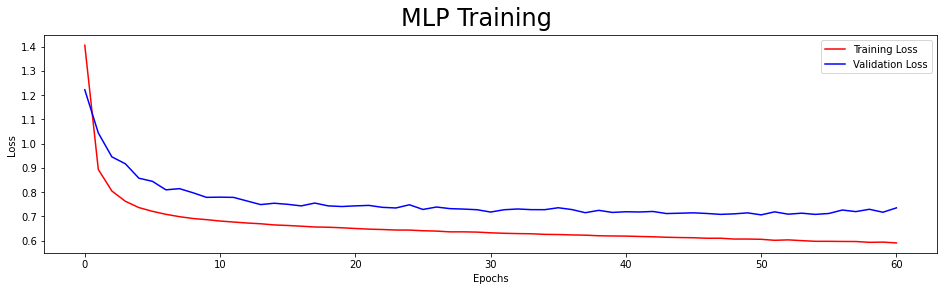

In [21]:
fig, ax = plt.subplots(figsize = (16,4))
ax.plot(history.history['loss'],'r',label = 'Training Loss')
ax.plot(history.history['val_loss'],'b',label = 'Validation Loss')
#ax[1].plot(history.history['accuracy'],'r',label = 'Training Accuracy')
#ax[1].plot(history.history['val_accuracy'],'b',label = 'Validation Accuracy')
ax.legend()
#ax[1].legend()
ax.set_xlabel('Epochs')
#ax[1].set_xlabel('Epochs');
ax.set_ylabel('Loss')
#ax[1].set_ylabel('Accuracy %');
fig.suptitle('MLP Training', fontsize = 24)
plt.show()

In [22]:

train_accuracy = model.evaluate(X,y_nn)[1]
print('Training Accuracy:',train_accuracy)


17770/17770 [==============================] - 0s 26us/sample - loss: 0.6139 - accuracy: 0.7846
Training Accuracy: 0.78458077


Clean up the test data in a similar manner to the train data

In [23]:
columns = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm', 'cdm','rdm','rwb','lb','lcb','cb','rcb','rb']
df_test[columns] = df_test[columns].fillna(30)
df_test[columns] = df_test[columns].astype(int)
columns = ['dribbling','defending','physic','passing','shooting','pace']

for col in columns:
    df_test[col] = df_test[col].fillna(df_test[col].median())
df_test[columns] = df_test[columns].astype(int)
df_test['contract_valid_until'] = df_test['contract_valid_until'].fillna(df_test['contract_valid_until'].max())
df_test = df_test.fillna(0)
df_test['player_positions'] = df_test['player_positions'].str.split(',',n=1,expand=True)[0]
df_test.head()

,age,overall,potential,value_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,release_clause_eur,team_position,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,High/High,High/Low,High/Medium,Low/High,Low/Low,Low/Medium,Medium/High,Medium/Low,Medium/Medium,bmi
0,32,94,94,95500000,RW,0,5,4,4,195800000.0,RW,2021.0,87,92,92,96,39,66,0.0,0.0,0.0,0.0,0.0,0.0,88,95,70,92,88,97,93,94,92,96,91,84,93,95,95,86,68,75,68,94,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89,89,89,93,93,93,93,93,93,93,93,92,87,87,87,92,68,66,66,66,68,63,52,52,52,63,0,0,0,0,0,0,0,1,0,24.913495
1,34,93,93,58500000,ST,1,5,4,5,96500000.0,LW,2022.0,90,93,82,89,35,78,0.0,0.0,0.0,0.0,0.0,0.0,84,94,89,83,87,89,81,76,77,92,89,91,87,96,71,95,95,85,78,93,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61,0,1,0,0,0,0,0,0,0,23.735308
2,27,92,92,105500000,LW,1,5,5,5,195200000.0,CAM,2022.0,91,85,87,95,32,58,0.0,0.0,0.0,0.0,0.0,0.0,87,87,62,87,87,96,88,87,81,95,94,89,96,92,84,80,61,81,49,84,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84,84,84,90,89,89,89,90,90,90,90,89,82,82,82,89,66,61,61,61,66,61,46,46,46,61,0,0,1,0,0,0,0,0,0,22.204082
3,26,91,93,77500000,GK,1,3,3,1,164700000.0,GK,2023.0,69,54,58,64,56,66,87.0,92.0,78.0,89.0,52.0,90.0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,89,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,30,0,0,0,0,0,0,0,0,1,24.615211
4,28,91,91,90000000,LW,1,4,4,4,184500000.0,LW,2024.0,91,83,86,94,35,66,0.0,0.0,0.0,0.0,0.0,0.0,81,84,61,89,83,95,83,79,83,94,94,88,95,90,94,82,56,84,63,80,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83,83,83,89,88,88,88,89,89,89,89,89,83,83,83,89,66,63,63,63,66,61,49,49,49,61,0,0,1,0,0,0,0,0,0,24.163265


In [24]:
y_test_nn = pd.get_dummies(df_test['player_positions'])
X_test = df_test.drop(['player_positions','team_position'],axis=1)
X_test = X_test[df_tst['club'].isin(clubs)]
y_test_nn = y_test_nn[df_tst['club'].isin(clubs)]
#X_test = MinMaxScaler().fit_transform(X_test)
X_tst = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_tst, index=X_test.index, columns=X_test.columns)
test_acc = model.evaluate(X_test,y_test_nn)[1]
print('Neural Network Test Accuracy: ',test_acc)

287/287 [==============================] - 0s 37us/sample - loss: 0.6756 - accuracy: 0.7666
Neural Network Test Accuracy:  0.76655054


The following barplot is count of each position that the model predicted vs the actual count of each position in the test data-set.

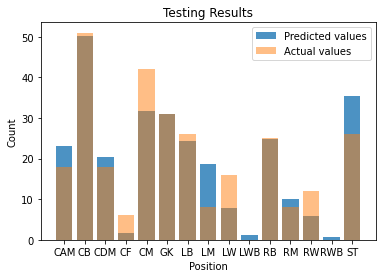

In [25]:
pos_pred = model.predict(X_test).sum(axis=0)
pos_actual = y_test_nn.sum(axis=0)
plt.bar(y_test_nn.columns,pos_pred,alpha=0.8,label='Predicted values')
plt.bar(y_test_nn.columns,pos_actual,alpha=0.5,label='Actual values')
plt.title('Testing Results')
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend()
plt.show()

The following barplot is count of each position that the model predicted vs the actual count of each position in the train data-set.

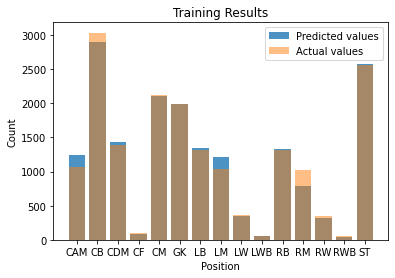

In [26]:
pos_pred = model.predict(X).sum(axis=0)
pos_actual = y_nn.sum(axis=0)
plt.bar(y_nn.columns,pos_pred,alpha=0.8,label='Predicted values')
plt.bar(y_nn.columns,pos_actual,alpha=0.5,label='Actual values')
plt.title("Training Results")
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend()
plt.show()

Following is the prediction divided into three major positions - defenders, mid-players and forward players. As we can see Defenders have been predicted to play in forward positions and even strikers have been predicted to play in defender positions.

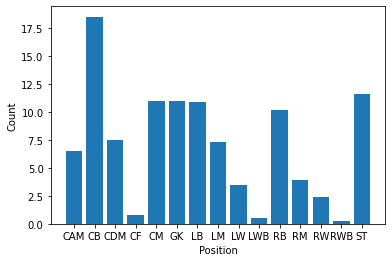

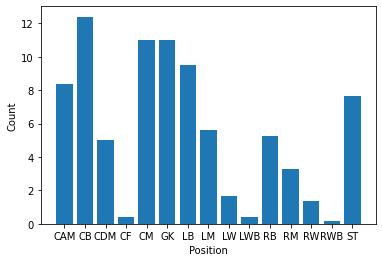

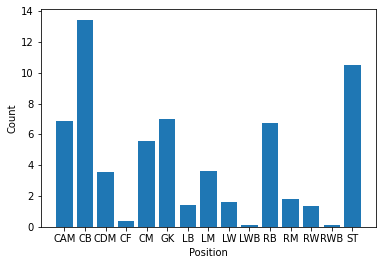

In [27]:
defenders = ['CB','CDM','LB','LWB','RB','RWB']
mid = ['CAM','CM','LM','RM']
forward = ['CF','LW','RW','ST']
y_19_actual = y_nn[df_tst['club'].isin(clubs)]
y_20_actual = y_test_nn
y_20_pre = model.predict(X_test)
y_20_pred = pd.DataFrame(y_20_pre, index=y_20_actual.index, columns=y_20_actual.columns)
pred_def = y_20_pred[(y_19_actual['CB'] == 1) | (y_19_actual['CDM'] == 1) | (y_19_actual['LB'] == 1) | (y_19_actual['LWB'] == 1)
                    | (y_19_actual['RB'] == 1) | (y_19_actual['RWB'] == 1)].sum(axis=0)
pred_mid = y_20_pred[(y_19_actual['CAM'] == 1) | (y_19_actual['CM'] == 1) | (y_19_actual['RM'] == 1) 
                    | (y_19_actual['LM'] == 1)].sum(axis=0)
pred_for = y_20_pred[(y_19_actual['CF'] == 1) | (y_19_actual['LW'] == 1) | (y_19_actual['RW'] == 1) 
                    | (y_19_actual['ST'] == 1)].sum(axis=0)
plt.figure()
plt.bar(y_nn.columns,pred_def)
plt.xlabel('Position')
plt.ylabel('Count')
plt.figure()
plt.bar(y_nn.columns,pred_mid)
plt.xlabel('Position')
plt.ylabel('Count')
plt.figure()
plt.bar(y_nn.columns,pred_for)
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()


# Part C - Which Club has the Best Staff  

**The best staff always help their players grow, can you identify that using historical data?**

Study player data from Division 1 European League* players from the last 5 Years. Analyze changes in player stats and value. Rank the clubs according to best increase in statistics of a player

Graphically represent the scores for the test set

**Details:** 

- Sofifa Id, URL, Wage, Salary, Name, Real face, URL variables cannot be used during the prediction or learning. 

- Assign a score to all clubs out of 100, and represent it in an appropriate visualization. With 100 being the highest 

- For the test set, your model will be scored using MSE against the average of all models of the class. (Score = MSE( Your Values , Average of all models values))

- The test set is as follows for this problem statement (Division 1 European League):

**Leagues to be considered**

 **Premier League - English Premier League **

# Web Scrapper

In [98]:
# Import necessary libraries
from bs4 import BeautifulSoup as bs
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

**We scraped the required data from `https://www.espn.in` using the package BeautifulSoup and created new csv files for each year with just the clubs belonging to the English Premier League**

In [99]:
# save year-wise team names in a dictionary
year_teams = {}
for year in range(2015, 2020):
    teams = []
    # get the webpage
    r = requests.get(f'https://www.espn.in/football/table/_/league/ENG.1/season/{year}')
    # convert to a beautiful soup object
    soup = bs(r.content)
    # find the required table that contains the team names
    table = soup.find(class_="Table__TBODY")
    # find all the table rows: each row will have one team name
    table_rows = table.find_all('tr')
    # loop through the table rows and extract the team name
    for row in table_rows:
        # find the anchor tags that contains a main single team name
        anchors = row.find_all('a')
        for i, anch in enumerate(anchors):
            if i == 2:
                # get the team name
                name = anch.get_text()
                # append team name to the list
                teams.append(name)
    # add the team list to a dictionary as a value and a year as a key
    year_teams[year] = teams

In [100]:
# teams participated in English Premier League 2015
year_teams[2015]

['Leicester City',
 'Arsenal',
 'Tottenham Hotspur',
 'Manchester City',
 'Manchester United',
 'Southampton',
 'West Ham United',
 'Liverpool',
 'Stoke City',
 'Chelsea',
 'Everton',
 'Swansea City',
 'Watford',
 'West Bromwich Albion',
 'Crystal Palace',
 'AFC Bournemouth',
 'Sunderland',
 'Newcastle United',
 'Norwich City',
 'Aston Villa']

## Create five csv files:
- year_2015: contains all data for clubs that participated in EPL 2015
- year_2016: contains all data for clubs that participated in EPL 2016
- year_2017: contains all data for clubs that participated in EPL 2017
- year_2018: contains all data for clubs that participated in EPL 2018
- year_2019: contains all data for clubs that participated in EPL 2019

In [102]:
# loop through a dictionary created above
for year, teams in year_teams.items():
    # define a list
    team_list = []
    # loop through each team in teams
    for team in teams:
        # load the appropriate dataset: for teams participated in 2015 -> load players_2015 dataset and so on.
        df_fifa = pd.read_csv(f'players_{str(year)[2:]}.csv')
        # assign the team data to a new dataframe
        df = df_fifa[df_fifa['club'] == team]
        # add df to the list
        team_list.append(df)
    # concatenate all the dataframe 
    fifa_df = pd.concat(team_list)
    # save the dataframe as csv file
    fifa_df.to_csv(f'data/year_{year}.csv', index=False)

# Analysis

In [110]:
# load all the data from the csv file we created and saved above
fifa_15 = pd.read_csv('data/year_2015.csv')
fifa_16 = pd.read_csv('data/year_2016.csv')
fifa_17 = pd.read_csv('data/year_2017.csv')
fifa_18 = pd.read_csv('data/year_2018.csv')
fifa_19 = pd.read_csv('data/year_2019.csv')

**We choose the variable 'Overall' as the main feature in order to study the performance of the club. With increase in 'Overall', we say that the club's performance has also increased.**

In [111]:
# Computing the average 'overall' of all the players in each club:

avg_15 = fifa_15.groupby('club')['overall'].mean()
avg_15_df = pd.DataFrame(avg_15.values, index=avg_15.index, columns=['overall_15']).reset_index()

avg_16 = fifa_16.groupby('club')['overall'].mean()
avg_16_df = pd.DataFrame(avg_16.values, index=avg_16.index, columns=['overall_16']).reset_index()

avg_17 = fifa_17.groupby('club')['overall'].mean()
avg_17_df = pd.DataFrame(avg_17.values, index=avg_17.index, columns=['overall_17']).reset_index()

avg_18 = fifa_18.groupby('club')['overall'].mean()
avg_18_df = pd.DataFrame(avg_18.values, index=avg_18.index, columns=['overall_18']).reset_index()

avg_19 = fifa_19.groupby('club')['overall'].mean()
avg_19_df = pd.DataFrame(avg_19.values, index=avg_19.index, columns=['overall_19']).reset_index()

# Merge all the data into a new dataframe
merge_df = [avg_16_df, avg_17_df, avg_18_df, avg_19_df] 
new_df = avg_15_df.copy()
for df in merge_df:
    new_df = new_df.merge(df, on='club', how='outer')
# print the head of new dataframe
new_df.head()

,club,overall_15,overall_16,overall_17,overall_18,overall_19
0,Arsenal,74.181818,74.437500,76.151515,75.757576,74.787879
1,Aston Villa,69.468750,NaN,NaN,NaN,68.800000
2,Chelsea,73.272727,76.321429,75.545455,76.515152,76.787879
3,Crystal Palace,69.424242,72.827586,71.272727,70.575758,71.121212
4,Everton,72.363636,74.357143,73.545455,74.727273,73.939394


**We can see from the above table that the clubs in the league are not consistent over the past 5 years. Therefore, we decided to drop clubs that didn't contribute to the 5-year statistic.**

# Scoring Method-1 (Average Increase)

In [112]:
# drop the clubs that are not consistent over the five years (2015-19)
new_df_drop = new_df.dropna()
new_df_drop

,club,overall_15,overall_16,overall_17,overall_18,overall_19
0,Arsenal,74.181818,74.437500,76.151515,75.757576,74.787879
2,Chelsea,73.272727,76.321429,75.545455,76.515152,76.787879
3,Crystal Palace,69.424242,72.827586,71.272727,70.575758,71.121212
4,Everton,72.363636,74.357143,73.545455,74.727273,73.939394
5,Leicester City,66.454545,69.387097,71.515152,72.181818,73.969697
6,Liverpool,73.060606,76.111111,74.727273,75.909091,76.000000
7,Manchester City,73.424242,77.206897,75.545455,74.121212,76.848485
8,Manchester United,73.393939,76.259259,77.906250,77.666667,77.454545
11,Southampton,68.909091,72.064516,71.939394,71.878788,71.424242
15,Tottenham Hotspur,73.484848,72.733333,73.030303,73.515152,75.969697


**We now see if there how the clubs have performed in terms of their average "Overall" in these past 5 years**

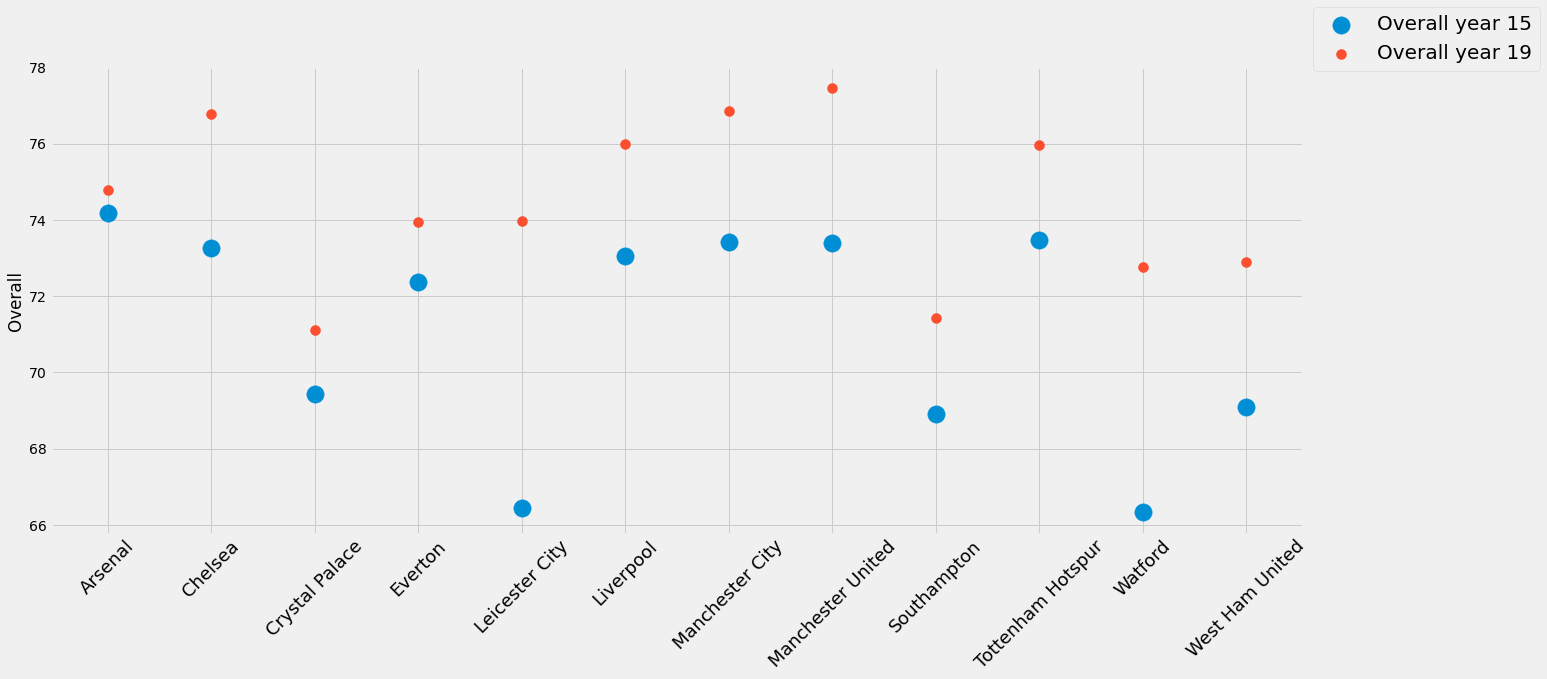

In [113]:
# create xticks for side-by-side bar plot. 
xticks1 = np.arange(12)
xticks2 = xticks1+0.4

plt.style.use('fivethirtyeight')
# plot
plt.figure(figsize=(20, 8))
plt.scatter(xticks1,new_df_drop['overall_15'], label="Overall year 15", s=300)
plt.scatter( xticks1,new_df_drop['overall_19'], label="Overall year 19", s=100)
plt.xticks(xticks1, new_df_drop['club'], fontsize=18, rotation=45)
plt.ylabel("Overall")
plt.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1, 1.15))
plt.show()

**It's good to see that all clubs have done well in the last 5 years. What is also interesting to note is that the English Premier League has a range of clubs with varied performance, with just four clubs lagging behind the rest, in terms of 'overall' in the year 2019.**

In [114]:
def cal_mean(team1, team2):
    #Computing the mean difference for a given club between two succesive years
    yearA = team1['overall']
    yearB = team2['overall']
    return (yearB.mean() - yearA.mean())

In [115]:
def overall_avg(clubs):
    #Computing the mean overall for each year and averaging over them
    score = {}
    for club in clubs:
        team_15 = fifa_15[fifa_15['club'] == club]
        team_16 = fifa_16[fifa_16['club'] == club]
        team_17 = fifa_17[fifa_17['club'] == club]
        team_18 = fifa_18[fifa_18['club'] == club]
        team_19 = fifa_19[fifa_19['club'] == club]
        
        score_15_16 = cal_mean(team_15, team_16)
        score_16_17 = cal_mean(team_16, team_17)
        score_17_18 = cal_mean(team_17, team_18)
        score_18_19 = cal_mean(team_18, team_19)
        
        mean_ = (score_15_16 + score_16_17 + score_17_18 + score_18_19)/4
        score[club] = mean_
    return score

In [116]:
# get the club names
clubs = new_df_drop.club.values
# calculate some scores using above funciton
scores_overall = overall_avg(clubs)
scores_overall

{'Arsenal': 0.15151515151514872,
 'Chelsea': 0.8787878787878789,
 'Crystal Palace': 0.42424242424242564,
 'Everton': 0.3939393939393945,
 'Leicester City': 1.878787878787879,
 'Liverpool': 0.7348484848484844,
 'Manchester City': 0.8560606060606055,
 'Manchester United': 1.0151515151515156,
 'Southampton': 0.6287878787878789,
 'Tottenham Hotspur': 0.6212121212121211,
 'Watford': 1.6060606060606055,
 'West Ham United': 0.9538352272727266}

In [117]:
# Converting the dictionary to DataFrame
score_ov_df = pd.DataFrame(data=scores_overall.values(), index=scores_overall.keys())
score_ov_df.reset_index(inplace=True)
# rename the columns
score_ov_df.columns = ["club", 'score']

# Scaling the scores within range 0 to 100
score_ov_df.score = ((score_ov_df.score - score_ov_df.score.min()) / (score_ov_df.score.max() - score_ov_df.score.min())) * 100
# sort dataframe in descending order using score
score_ov_df.sort_values("score", ascending=False, inplace=True)

# merge the score_ov_df with new_df_drop with respect to club
merged_ov_df = new_df_drop.merge(score_ov_df,on='club')
# sort using score in descendiing order
merged_ov_df.sort_values("score", ascending=False, inplace=True)
merged_ov_df

,club,overall_15,overall_16,overall_17,overall_18,overall_19,score
4,Leicester City,66.454545,69.387097,71.515152,72.181818,73.969697,100.000000
10,Watford,66.333333,71.321429,71.606061,74.181818,72.757576,84.210526
7,Manchester United,73.393939,76.259259,77.906250,77.666667,77.454545,50.000000
11,West Ham United,69.093750,70.451613,72.545455,71.484848,72.909091,46.450110
1,Chelsea,73.272727,76.321429,75.545455,76.515152,76.787879,42.105263
6,Manchester City,73.424242,77.206897,75.545455,74.121212,76.848485,40.789474
5,Liverpool,73.060606,76.111111,74.727273,75.909091,76.000000,33.771930
8,Southampton,68.909091,72.064516,71.939394,71.878788,71.424242,27.631579
9,Tottenham Hotspur,73.484848,72.733333,73.030303,73.515152,75.969697,27.192982
2,Crystal Palace,69.424242,72.827586,71.272727,70.575758,71.121212,15.789474


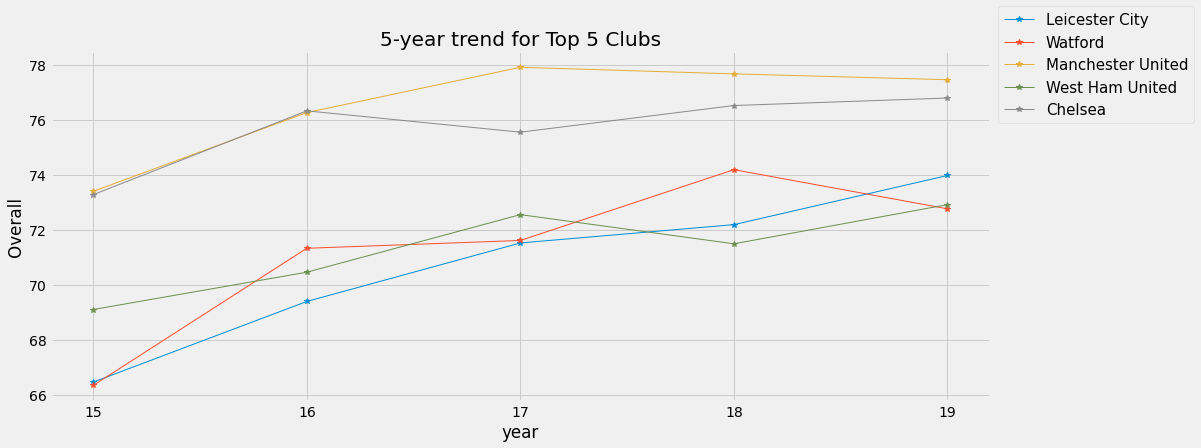

In [118]:
plt.figure(figsize=(15,6))
for i in range(0,5):
    plt.plot(list(merged_ov_df.iloc[i,1:-1].values), marker='*', linewidth=1, label=merged_ov_df.iloc[i,0])
plt.legend(fontsize=15, loc='upper left', bbox_to_anchor=(1, 1.15))
plt.xticks([0,1,2,3,4], labels=['15','16','17','18','19'])
plt.xlabel("year")
plt.ylabel("Overall")
plt.title("5-year trend for Top 5 Clubs")
plt.show()

**We can see why our scoring method is flawed here. Despite Arsenal having consistently good overall average it scored the least, while the highest score went to the club which had the maximum increase over the past 5 years. This doesn't neccessarily mean that the club isn't the best performed, or that it is. We need to find a scoring method that looks at how high their overall is for each year and also accesses if there has been an increase from year to year and not necessarily by how much there has been an increase.**

**But we still want to see if this scoring method changes the order if we only consider players who have been in the club for all the past 5 years and compute only their weighted average.**

# Scoring Method-2 Average Increase (Consistent Players)

In [119]:
def cal_sum(team1, team2):
    #computing the sum of all the players who are in all 5 years for a given club
    team_1_2 = team1[team1['sofifa_id'].isin(team2['sofifa_id'])]['overall']

    team_2_1 = team2[team2['sofifa_id'].isin(team1['sofifa_id'])]['overall']

    return len(team_1_2), (team_2_1.sum() - team_1_2.sum())

In [120]:
def calculate(clubs):
    #For players consistent in all 5 years
    score = {}
    for club in clubs:
        team_15 = fifa_15[fifa_15['club'] == club]
        team_16 = fifa_16[fifa_16['club'] == club]
        team_17 = fifa_17[fifa_17['club'] == club]
        team_18 = fifa_18[fifa_18['club'] == club]
        team_19 = fifa_19[fifa_19['club'] == club]
        
        l1, score_15_16 = cal_sum(team_15, team_16)
        l2, score_16_17 = cal_sum(team_16, team_17)
        l3, score_17_18 = cal_sum(team_17, team_18)
        l4, score_18_19 = cal_sum(team_18, team_19)
        
        sum_ = (score_15_16 + score_16_17 + score_17_18 + score_18_19) / (l1+l2+l3+l4)
        score[club] = sum_
    return score

In [121]:
scores = calculate(clubs)

In [122]:
score_df = pd.DataFrame(data=scores.values(), index=scores.keys())
score_df.reset_index(inplace=True)

score_df.columns = ["club", 'score']

In [123]:
# Scaling the scores to fall between 0 and 100
score_df.score = ((score_df.score - score_df.score.min()) / (score_df.score.max() - score_df.score.min())) * 100
score_df.sort_values("score", ascending=False, inplace=True)

In [124]:
merged_df = new_df_drop.merge(score_df,on='club')
merged_df.sort_values("score", ascending=False, inplace=True)

Text(0, 0.5, 'Clubs')

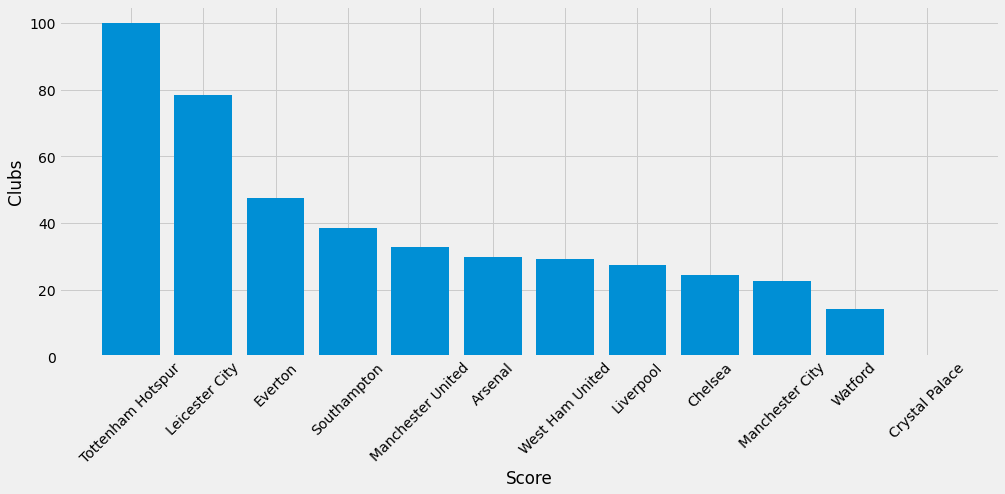

In [125]:
plt.figure(figsize=(15,6))
plt.bar(merged_df.club, merged_df.score)
plt.xticks(rotation=45)
plt.xlabel("Score")
plt.ylabel("Clubs")

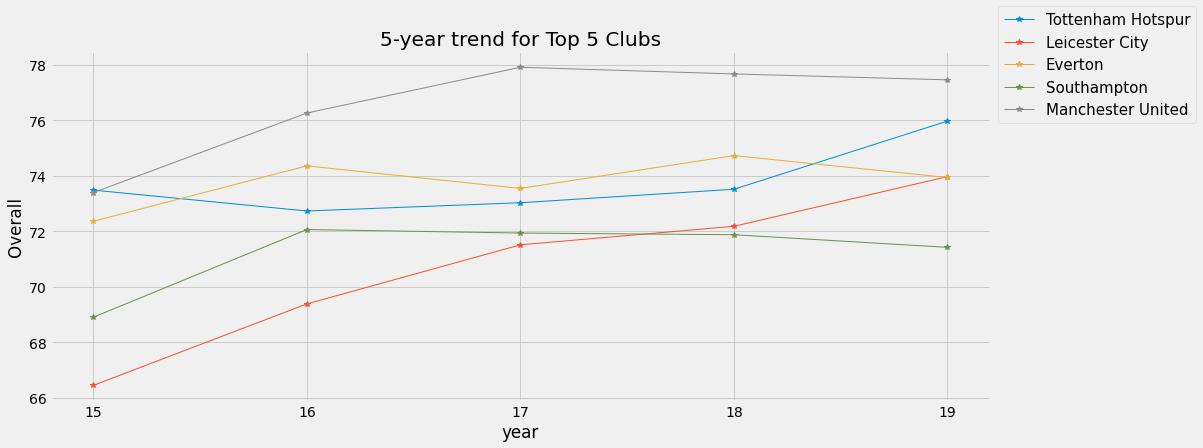

In [126]:
plt.figure(figsize=(15,6))
for i in range(0,5):
    plt.plot(list(merged_df.iloc[i,1:-1].values), marker='*', linewidth=1, label=merged_df.iloc[i,0])
plt.legend(fontsize=15, loc='upper left', bbox_to_anchor=(1, 1.15))
plt.xticks([0,1,2,3,4], labels=['15','16','17','18','19'])
plt.xlabel("year")
plt.ylabel("Overall")
plt.title("5-year trend for Top 5 Clubs")
plt.show()

**But owing to the inconsistencies in the previous scoring method in adequately measuring the average 'overall' increase in clubs, we resort to a ranking method, whereby the clubs are ranked from 1 to 12, with 1 being the best, for the average overall, for each year. Then the mean rank is computed from which we use proportionality to represent the scores from 1 - 12 to 100 - 8.33(100/12).**

# Scoring Method-3 (Based on Ranking)
We calculated the ranks of the clubs for each year using the average `overall` from each year. And then we calculated the average rank and assigned the scores to the clubs based on the average rank.

In [127]:
#Ranking each year and appending to dataframe
new = new_df_drop.sort_values('overall_15', ascending=False)
new['rank15']=np.arange(1,13)
new = new.sort_values('overall_16', ascending=False)
new['rank16']=np.arange(1,13)
new = new.sort_values('overall_17', ascending=False)
new['rank17']=np.arange(1,13)
new = new.sort_values('overall_18', ascending=False)
new['rank18']=np.arange(1,13)
new = new.sort_values('overall_19', ascending=False)
new['rank19']=np.arange(1,13)
new

,club,overall_15,overall_16,overall_17,overall_18,overall_19,rank15,rank16,rank17,rank18,rank19
8,Manchester United,73.393939,76.259259,77.906250,77.666667,77.454545,4,3,1,1,1
7,Manchester City,73.424242,77.206897,75.545455,74.121212,76.848485,3,1,3,7,2
2,Chelsea,73.272727,76.321429,75.545455,76.515152,76.787879,5,2,4,2,3
6,Liverpool,73.060606,76.111111,74.727273,75.909091,76.000000,6,4,5,3,4
15,Tottenham Hotspur,73.484848,72.733333,73.030303,73.515152,75.969697,2,8,7,8,5
0,Arsenal,74.181818,74.437500,76.151515,75.757576,74.787879,1,5,2,4,6
5,Leicester City,66.454545,69.387097,71.515152,72.181818,73.969697,11,12,11,9,7
4,Everton,72.363636,74.357143,73.545455,74.727273,73.939394,7,6,6,5,8
18,West Ham United,69.093750,70.451613,72.545455,71.484848,72.909091,9,11,8,11,9
16,Watford,66.333333,71.321429,71.606061,74.181818,72.757576,12,10,10,6,10


In [128]:
mean_list = []
for i in range(0,12):
    mean_rank = new.iloc[i,6:].values.astype(float).mean()
    mean_list.append(mean_rank)
new['mean_rank'] = mean_list

In [129]:
score1 = []
for i in range(0,12):
    scorea = (12 -new.iloc[i,-1])*100/12
    score1.append(scorea)
new['score1'] = score1
new

,club,overall_15,overall_16,overall_17,overall_18,overall_19,rank15,rank16,rank17,rank18,rank19,mean_rank,score1
8,Manchester United,73.393939,76.259259,77.906250,77.666667,77.454545,4,3,1,1,1,2.0,83.333333
7,Manchester City,73.424242,77.206897,75.545455,74.121212,76.848485,3,1,3,7,2,3.2,73.333333
2,Chelsea,73.272727,76.321429,75.545455,76.515152,76.787879,5,2,4,2,3,3.2,73.333333
6,Liverpool,73.060606,76.111111,74.727273,75.909091,76.000000,6,4,5,3,4,4.4,63.333333
15,Tottenham Hotspur,73.484848,72.733333,73.030303,73.515152,75.969697,2,8,7,8,5,6.0,50.000000
0,Arsenal,74.181818,74.437500,76.151515,75.757576,74.787879,1,5,2,4,6,3.6,70.000000
5,Leicester City,66.454545,69.387097,71.515152,72.181818,73.969697,11,12,11,9,7,10.0,16.666667
4,Everton,72.363636,74.357143,73.545455,74.727273,73.939394,7,6,6,5,8,6.4,46.666667
18,West Ham United,69.093750,70.451613,72.545455,71.484848,72.909091,9,11,8,11,9,9.6,20.000000
16,Watford,66.333333,71.321429,71.606061,74.181818,72.757576,12,10,10,6,10,9.6,20.000000


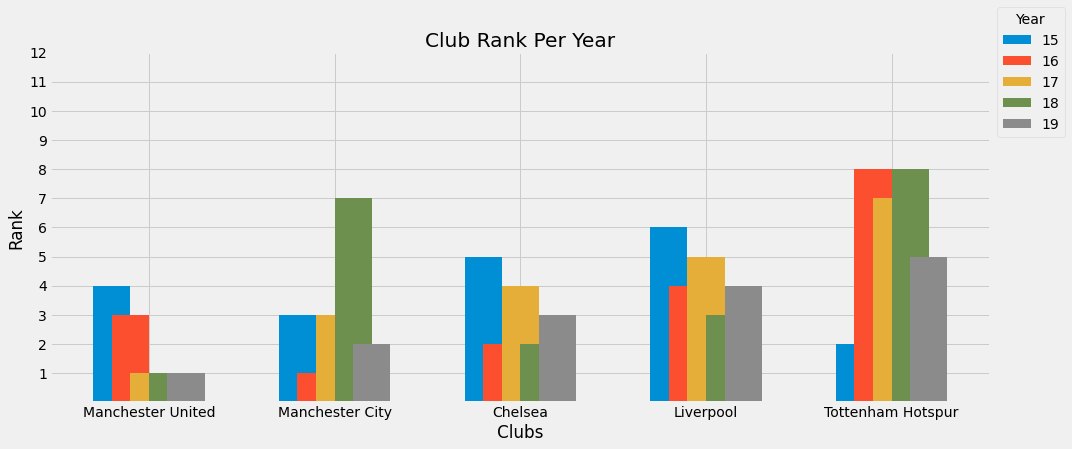

In [130]:
xticks = np.arange(5)
plt.figure(figsize=(15,6))
plt.bar(xticks, new.head(5)['rank15'], width=0.2, label='15')
plt.bar(xticks+0.1, new.head(5)['rank16'], width=0.2, label='16')
plt.bar(xticks+0.2, new.head(5)['rank17'], width=0.2, label='17')
plt.bar(xticks+0.3, new.head(5)['rank18'], width=0.2, label='18')
plt.bar(xticks+0.4, new.head(5)['rank19'], width=0.2, label='19')
plt.yticks(np.arange(1,13))
plt.xticks(xticks+0.2, labels=new.head()['club'])
plt.xlabel("Clubs")
plt.ylabel("Rank")
plt.title("Club Rank Per Year")
plt.legend(title="Year", loc='upper left', bbox_to_anchor=(1, 1.15))
plt.show()

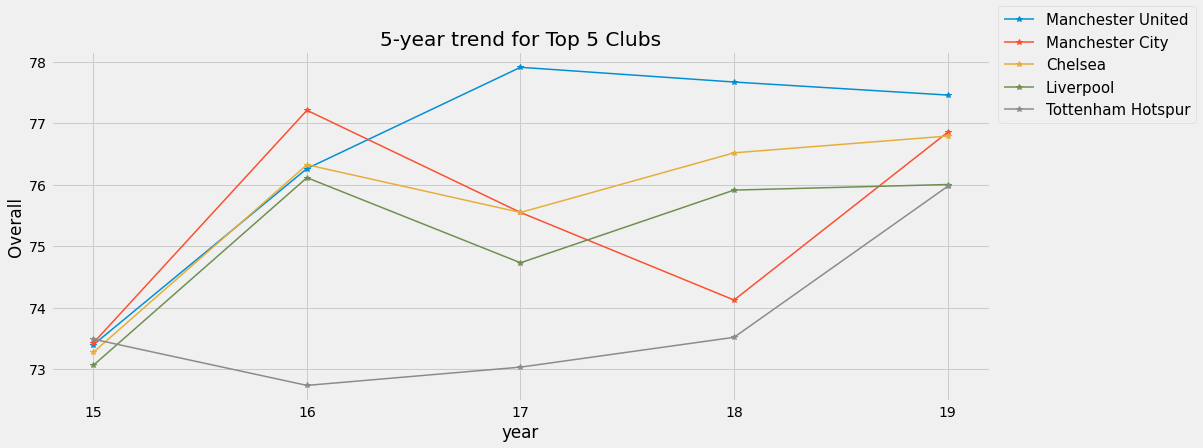

In [131]:
plt.figure(figsize=(15,6))
for i in range(0,5):
    plt.plot(list(new.iloc[i,1:6].values), marker='*', linewidth=1.5, label=new.iloc[i,0])
plt.legend(fontsize=15, loc='upper left', bbox_to_anchor=(1, 1.15))
plt.xticks([0,1,2,3,4], labels=['15','16','17','18','19'])
plt.xlabel("year")
plt.ylabel("Overall")
plt.title("5-year trend for Top 5 Clubs")
plt.show()

Text(0, 0.5, 'Clubs')

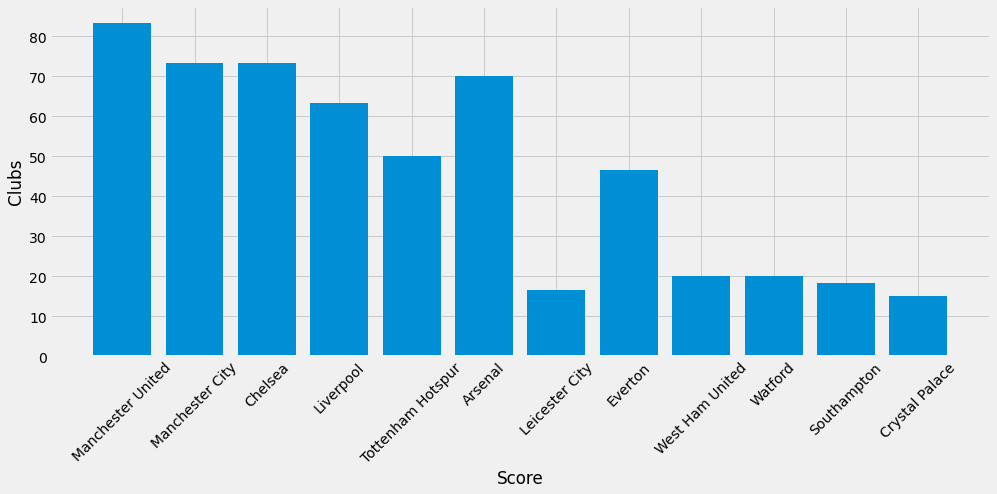

In [132]:
plt.figure(figsize=(15,6))
plt.bar(new.club, new.score1)
plt.xticks(rotation=45)
plt.xlabel("Score")
plt.ylabel("Clubs")

**We see a significant difference in the scores from both methods. While the ranking method is not perfect, and perhaps the inclusion of other predictors might have delievered a better score, the ranking method takes into account how consistent the clubs have been in mainintaing their "overall" average.**

# MSE 
**We compare scoring method 1, method 2 and another set of scores from Harshita's and Atharva's team and compare it with the scores we obtained for method 3..**

In [133]:
# this is the score that Harshita(from another group) shared with us
harshita_scores = {
    'Tottenham Hotspur': 2.931625703843884,
    'Leicester City': 14.491829494903971,
    'Everton': 1.1601282742347887,
    'Manchester United': 97.48895723747833,
    'Southampton': 1.422091768241594,
    'Arsenal': 10.19000678617647,
    'West Ham United': 8.725488568653235,
    'Liverpool': 1.5588594432045118,
    'Chelsea': 7.4841253147532365,
    'Manchester City': 12.856434014724837,
    'Watford': 3.451252278890241,
    'Crystal Palace': 25.573254209448624
}

# saving the scores as a dataframe
test_scores_df = pd.DataFrame(harshita_scores.values(), harshita_scores.keys())
test_scores_df.reset_index(inplace=True)
test_scores_df.drop('index', axis=1)
test_scores_df.columns = ['club', 'score']
test_scores_df

,club,score
0,Tottenham Hotspur,2.931626
1,Leicester City,14.491829
2,Everton,1.160128
3,Manchester United,97.488957
4,Southampton,1.422092
5,Arsenal,10.190007
6,West Ham United,8.725489
7,Liverpool,1.558859
8,Chelsea,7.484125
9,Manchester City,12.856434


In [134]:
# make a copy of dataframe
test_df = new.copy()
test_df = test_df.merge(test_scores_df, on='club', how='outer')

### Merge all the scores with respect to clubs and calculate the MSE

In [138]:
# get the score from method-1
score_1_df = merged_ov_df[['club', 'score']]
score_1_df.columns = ['club', 'm1_score']

# get the score from method-3
score_2_df = merged_df[['club', 'score']]
score_2_df.columns = ['club', 'm2_score']

# get the score from method-3 and other (harshita's score)
score_3_df = test_df[['club', 'score1', 'score']]
score_3_df.columns = ['club', 'm3_score', 'other_score']

# merge all above dataframe into one
final_score_df = score_1_df.merge(score_2_df, on='club')
final_score_df = final_score_df.merge(score_3_df, on='club')

# load new model score
new_score = pd.read_csv('data/staff_scores.csv')
# removed the unnecessary column
new_score.drop('Unnamed: 0', axis=1, inplace=True)
# rename the columns to make it mergeable
new_score.columns = ['club', 'other_score_1']
# merge with our final_score_df
final_score_df1 = final_score_df.merge(new_score, on='club')
# calculate the average from all the scores excluding m3_score (our final score)
final_score_df1['avg_score'] = (final_score_df1['m1_score'] + final_score_df1['m2_score'] + final_score_df1['other_score'] + final_score_df1['other_score_1']) / 4

In [139]:
# m1_score: calculated using method-1
# m2_score: calculated using method-2
# m3_score: calculated using method-3
# other_score: score shared by Harshita
# other_score_1: score shared by Atharva
# avg_score: average of m1_score, m2_score, other_score and other_score_1
final_score_df1

,club,m1_score,m2_score,m3_score,other_score,other_score_1,avg_score
0,Leicester City,100.000000,78.530664,16.666667,14.491829,100.000000,73.255623
1,Watford,84.210526,14.314919,20.000000,3.451252,86.507586,47.121071
2,Manchester United,50.000000,32.908325,83.333333,97.488957,40.439814,55.209274
3,West Ham United,46.450110,29.286023,20.000000,8.725489,18.669611,25.782808
4,Chelsea,42.105263,24.341639,73.333333,7.484125,74.732039,37.165767
5,Manchester City,40.789474,22.710390,73.333333,12.856434,24.872632,25.307232
6,Liverpool,33.771930,27.429776,63.333333,1.558859,60.670714,30.857820
7,Southampton,27.631579,38.549989,18.333333,1.422092,65.275599,33.219815
8,Tottenham Hotspur,27.192982,100.000000,50.000000,2.931626,36.232123,41.589183
9,Crystal Palace,15.789474,0.000000,15.000000,25.573254,4.456090,11.454705


In [140]:
# calculate mean squared error using the 
mse = mean_squared_error(final_score_df1.avg_score, final_score_df1.m3_score)
# print the mse
print("Final MSE: {:.2f}".format(mse))

Final MSE: 1094.91


**One can argue that the high MSE can be due to obviously the very different scoring methods and most importantly the different scaling used to bring the scores to 100. The high MSE can also be due to sparse availability of models to compare with. Further speculations about the MSE cannot be made without standardising the scaling and learning about the other team's scoring methods.**